## Link to data:
 https://clinecenter.illinois.edu/project/research-themes/democracy-and-development/coup-detat-project-cdp

### Contents of this notebook
- Introduction to Project
- Variables list
- Preparing the Data
- Choosing our Response variable
- Missing Data 
- Preliminary Visuals
- Model Selection
    - Predictor Pre Selection with Problematic Predictors
    - Baseline Model
        - Scaling  
        - LogisticRegressionCV
    - Improved Modeling
        - Two & three way interaction terms
        - Lasso Penalization on interaction terms
        - Univariate Feature Selection
            - Chi Squared
            - Mutual Information Classifier
        - Modeling after feature selection
            - LogisticRegressionCV
                - Estimating False Positive and False Negative Rates
            - Random Forest
                - Estimating False Positive and False Negative Rates
    - CS109 Modeling
        - Multi Layer Perceptron
            - Estimating False Positive and False Negative Rates
- Extension Questions
    - Initial Predictor Selection 
    - Exploration of potential interests
    - Comparision of Sub-Regions
        - Scaling, Lasso, & LogisticRegressionCV
        - Visualization of predictors
    - Comparision of Time Frames
        - Scaling, Lasso, & LogisticRegressionCV
        - Visualization of predictors
    





## Introduction to our Project
Our project looks at the Coup d'etats around the world across different years. Our data comes from the Cline Center from the University of Illinois Urbana-Champaign. The link to the website and data is: https://clinecenter.illinois.edu/project/research-themes/democracy-and-development/coup-detat-project-cdp

From the Cline Center website, a coup is labeled as "organized efforts to effect sudden and irregular(e.g. illegal or extra-legal) removal of the incumbent executive authority of a national government, or to displace the authority of the highest levels of one or more branches of the government." A coup is considered to be realized or unrealized. A realized coup would be a success in the removal of the incumbents or the removal of the incumbents ability to control the state. An unrealized coup is considered to be a conspiracy or an attempted coup, meaning an unsuccessful removal of an incumbent's power. Please note that we will be using realized coup or success or coup interchangeably to mean a success. Also note, that a coup technically includes conspiracies or attempts but these will be described as either unrealized, unsuccessful or as they are mentioned.


While we are mainly interested in understanding what constitutes a successful coup, we want to look at more than just what makes a coup successful generically. What if there is a difference in what determines a coup post WWII? Would a scenario that made a successful coup in Chile work in Russia? Would it work in South Africa? We have the ability to make predictions of what success means as a whole but also tailor it to more specific scenarios.


## Dataset 

The dataset contains the following columns: 

- `coup_id` - Unique number assigned to each event. It consists of the country’s cowcode and the eight digit date of the event in MMDDYYYY.
- `cowcode` - A unique country code number based on the Correlates of War (COW) country code list4. It is used to identify the country where a coup event occurred. Please note, these codes are slightly different from
- `country` - Name of the country where the coup event occured 
- `year` -  Year of the coup event.
- `month` -  Month of the coup event.
- `day` -  Day of the coup event. 
- `event_type` - Indicates whether the event is a coup, attempted coup, or conspiracy.
- `unrealized` -  A dummy variable where one indicates an unsuccessful coup or plot and zero otherwise.
- `realized` -  A dummy variable where one indicates a successful coup and zero otherwise.
- `conspiracy` - A dummy variable where one indicates a coup conspiracy thwarted prior to execution and zero otherwise.
- `attempt` -  A dummy variable where one indicates a coup was attempted by failed and zero otherwise.
- `military` - A dummy variable where one indicates a military coup/attempt/conspiracy and zero otherwise.
- `dissident` - A dummy variable where one indicates a dissident coup/attempt/conspiracy and zero otherwise.
- `rebel` - A dummy variable where one indicates a rebel coup/attempt/conspiracy and zero otherwise.
- `palace` - A dummy variable where one indicates a palace coup/attempt/conspiracy and zero otherwise.
- `foreign` - A dummy variable where one indicates a foreign-backed coup/attempt/conspiracy and zero otherwise.
- `auto` - A dummy variable where one indicates an auto coup and zero otherwise.
- `resign` - A dummy variable where one indicates a forced resignation and zero otherwise
- `popular` - A dummy variable where one indicates a popular revolt and zero otherwise.
- `counter` - A dummy variable where one indicates a counter-coup and zero otherwise.
- `other` - A dummy variable where one indicates the coup event does not fit into any of the above categories or the actors were not identified and zero otherwise.
- `noharm` - A dummy variable where one indicates the deposed executive was not harmed during the coup event and zero otherwise.
- `injured` - A dummy variable where one indicates the deposed executive was injured during the coup event and zero otherwise.
- `killed` -  A dummy variable where one indicates the deposed executive was killed during the coup event and zero otherwise.
- `harrest` - A dummy variable where one indicates the deposed executive was placed under house arrest and zero otherwise.
- `jailed` -  A dummy variable where one indicates the deposed executive was jailed and zero otherwise.
- `tried` - A dummy variable where one indicates the deposed executive was tried and zero otherwise.
- `fled` - A dummy variable where one indicates the deposed executive fled the country and zero otherwise.
- `exile` - A dummy variable where one indicate the deposed executive was banished from the country and zero otherwise.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error                       
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
import itertools
from IPython.display import clear_output
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from prettytable import PrettyTable
import warnings 

warnings.filterwarnings("ignore")


## Preparing the data

- Choosing the response Variable as `realized`, meaning that the event was a successful coup. 
    - The variable `realized` is 1 when the coup was successful. It is 0 when the event was a conspiracy or an attempt. 
- Gather a list of the countries with coups and their success rates
- Find a country with the most coups (not the rate of success)

In [2]:
coup_df = pd.read_csv('Coupdata.csv')
coup_df.head()

,coup_id,cowcode,country,year,month,day,event_type,unrealized,realized,conspiracy,...,counter,other,noharm,injured,killed,harrest,jailed,tried,fled,exile
0,43910302014,439,Burkina Faso,2014,10,30,coup,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,51605132015,516,Burundi,2015,5,13,attempted,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,48304132006,483,Chad,2006,4,13,attempted,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,65102112011,651,Egypt,2011,2,11,coup,0,1,0,...,0,0,1,0,0,0,1,1,0,0
4,65107032013,651,Egypt,2013,7,3,coup,0,1,0,...,0,0,1,0,0,0,1,1,0,0


# Functions Used
Here is a series of cells that contain functions we will call throughout the notebook.

###  Estimating our False Positive and False Negative Rates
With categorical data, it is important to go back and check what the False Positive Rate (FPR) and False Negative Rate. This can give us insight to how our model is performing along side the accuracies that were computed. A FPR is when the prediction is positive or 1 whereas the true test value is negative or 0. A FNR is when the prediction is negative or 0 whereas the true test value is positive or 1. These rates can allow us to understand how many times we are incorrectly guessing and whether or not our model potentially favors FPR or FNR. 

We will begin by plotting the ROC curve of our train data to see how the comparision of FPR and FNR look. We will then calculate the actual FPR and FNR. These were placed into different functions so that we can continue to call these inorder to look at the FPR and FNR across any model run.

In [3]:
# Calculating FP and FN rates using train 
def calculate_rates(y_true,y_pred, ):
    ''' This function takes in a column vector of predictions (y_pred) that should be the same length of 
    the true values (y_true). It will return the False Positive and False negative rates as well as print
    them.
    '''
    FP = ((y_pred == 1 )&(y_true == 0)).sum()
    all_neg = (y_true == 0).sum()
    FPR = FP/all_neg
    print(f"The calculated false positive rate based off our model: {FPR:.3f}")

    #FN
    FN = ((y_pred == 0 )&(y_true == 1)).sum()
    all_pos = (y_true == 1).sum()
    FNR = FN/all_pos
    print(f"The calculated false negative rate based off our model: {FNR:.3f}")
    return FPR, FNR

In [4]:
def find_rates(y_true, yhat):  
    '''
    This function takes in a yhat that should come from using predict proba on a fitted model and the
    true values (y_true). Both should be the same length. This will calculate a running False positive
    and False negative rate for 1000 thresholds. It will return those values as well as the accuracy 
    of the model at each threshold. This is a helper function that will be used in plotting.
    '''
    thresholds_list = np.linspace(0,1,1000)

    FP_rate, FN_rate, accuracy_list = [],[], []
   

    for i in thresholds_list:
        class_label = (yhat > i).astype(int)
        accuracy = (class_label == y_true).mean()
        accuracy_list.append(accuracy)

        #All False Positive
        FP = ((class_label == 1) & (y_true == 0)).sum()
        all_neg = (y_true == 0).sum()
        FPR = FP/all_neg
        FP_rate.append(FPR)

        # False Negative
        FN = ((class_label == 0) & (y_true == 1)).sum()
        all_pos = (y_true == 1).sum()
        FNR = FN/all_pos

        FN_rate.append(FNR)
        
     
    return FP_rate, FN_rate, accuracy_list

In [5]:
def rates_plot(y_true,yhat):#,FP_rate, FN_rate, accuracy_list):
    '''
    This function takes in a yhat from predict proba that uses a fitted model and a column of true values.
    This function will plot the ROC curve associated to the yhat and y_true passed. It will also require 
    the outputs from the function above to plot the FPR and FNR for a series of thresholds
    '''
    
    fpr, tpr, thresholds = roc_curve(y_true, yhat)
    thresholds_list = np.linspace(0,1,1000)
    FP_rate, FN_rate, accuracy_list =find_rates(y_true, yhat) 
    
    
    fig = plt.figure(figsize = (30, 10))
    ax1 = plt.subplot(2,3,1)
    ax2 = plt.subplot(2,3,2)
    

    #ROC Plots
    x=np.arange(0,100)/100
    ax1.plot(x,x,'--',color="gray",alpha=0.3, label = "random classifier")
    ax1.plot([0,1],[1,1],'--',color="magenta", label = "perfect classifier")
    ax1.plot([0,0],[0,1],'--',color="magenta")
    ax1.plot(fpr,tpr,'-',label="Our Model") 
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_title("ROC Curve for our Model")
    ax1.legend()
   


    ax2.plot(thresholds_list,FP_rate,label = "FPR")
    ax2.plot(thresholds_list,FN_rate ,label = "FNR")
    ax2.plot(thresholds_list,accuracy_list, label = "Accuracies")
    ax2.axvline(x=0.5, c = 'm', ls = '--',label = 'Predict Proba Threshold')
    ax2.set_title("Comparision of thresholds for False Positive Rates and False Negative Rates")
    ax2.set_ylabel("Rates")
    ax2.set_xlabel("Threshold")
    ax2.set_xlim([0,1])
    ax2.legend(loc = 'upper right')

In [6]:
def print_coefs(coefs_list):
    """
    Takes a list of tuples (predictor, coefficient) and prints only the sorted positives and negatives coefficients.
    """
    # Separate negatives and positives
    positives, negatives = [], []
    for predictor, coef in coefs_list:
        if coef > 0.0000: 
            positives.append((predictor, coef))
        if coef < 0.0000:
            negatives.append((predictor, coef))

    # Sort 
    positives.sort(key=lambda x:x[1])
    negatives.sort(key=lambda x:x[1])

    print("Sorted Positive Coefficients")
    for predictor, coef in positives:
        print("\t{:<30}{:.4f}".format(predictor, coef))
    print("---------------------------------------------")
    print("Sorted Negative Coefficients")
    print("")
    for predictor, coef in negatives:
        print("\t{:<30}{:.4f}".format(predictor, coef))

### Choosing our Response Variable: 
We decided to use the column `realized` as our response variable that is based off of event type. Event type has three categories (coup, attempted, conspiracy). This  column in the dataframe will be based off the event_type column and will create a list of 1s or 0s to signify whether a coup was successful (1) or unsuccesful (0). The unrealized column is the exact opposite which shows failures as (1) and successes as (0). Since unrealized is the exact opposite we will drop this from the list of chosen predictors.

In [7]:
event_types = coup_df.event_type.unique()
print("The metrics used to determine a successful coup:", event_types)
print("If the event type is a coup it counts as a real or a 1 whereas attempted and conspiracy are considered a unrealized coup given a 0.")



The metrics used to determine a successful coup: ['coup' 'attempted' 'conspiracy']
If the event type is a coup it counts as a real or a 1 whereas attempted and conspiracy are considered a unrealized coup given a 0.


### Cowcodes instead of using countries

In [8]:
coup_df_selected = coup_df.copy()
coup_df_selected = coup_df_selected.drop(columns = ['country', 'coup_id', 'event_type', 'unrealized'])
y = coup_df_selected['realized']
x = coup_df_selected.drop(columns = 'realized')
predictors_list = x.columns.values.tolist()
#predictors_list

In [9]:
coup_df['cowcode'].unique
cowcodes_countries = pd.DataFrame()
cowcodes_countries['country'] = coup_df['country']
cowcodes_countries['cowcode'] = coup_df['cowcode']
cowcodes_countries.shape
cowcodes_countries = cowcodes_countries.drop_duplicates(subset=['cowcode'])
print(f"We have {cowcodes_countries.shape[0]} cowcodes.")

We have 134 cowcodes.


In [10]:
countries = pd.DataFrame()
countries['country'] = coup_df['country']
countries['cowcode'] = coup_df['cowcode']
countries = countries.drop_duplicates(subset=['country'])
print(f"We have {countries.shape[0]} countries.")

#countries

We have 136 countries.


We have 136 countries and 134 cowcodes, because the person inputing the data did a mistake in inputing the name of the country - they named the same country with the according name in different languages.

The countries that has cowcodes in common are: Cote d'Ivoire and Ivory coast (cowcode 437) and Kyrgyzstan and Kyrgyz Republic (code 703). 
Essentially, these are the same country, simply imputed with different names. 

Consequently, we actually 134 countries and not 136. 

Hence we will keep cowcodes as variable to indicate the country.



In [11]:
code_437 =countries[ countries['cowcode']  == 437]
print(code_437)

code_703 =countries[ countries['cowcode']  == 703]
print(code_703)

ivory = coup_df.iloc[48]
ivoire = coup_df.iloc[276]

kyrgyzstan = coup_df.iloc[39]
kyrgyz_republic = coup_df.iloc[517]

           country  cowcode
48     Ivory Coast      437
276  Cote d'Ivoire      437
             country  cowcode
39        Kyrgyzstan      703
517  Kyrgyz Republic      703


## Checking for Missing Data

We will explore whether or not the dataframe is missing any data for any of the predictors so we can decide our imputation means. Our data looks to not have any missing data!

In [12]:
coup_df.isna().sum()

coup_id       0
cowcode       0
country       0
year          0
month         0
day           0
event_type    0
unrealized    0
realized      0
conspiracy    0
attempt       0
military      0
dissident     0
rebel         0
palace        0
foreign       0
auto          0
resign        0
popular       0
counter       0
other         0
noharm        0
injured       0
killed        0
harrest       0
jailed        0
tried         0
fled          0
exile         0
dtype: int64

## Preliminary Visuals
This will analyze the predictors that were selected and tested from the model selection. We will do multiple methods of evaluating these predictors and their affect on the response variable. This will include plotting how each predictor's presence impacted the outcome of the coup. This can also help use reduce the list of predictors if we see any weird plots.

### Subplots showing the chosen categorical variables vs Event type variable

Predictors: ['country','year','military','dissident','rebel','palace', 'foreign','auto','resign','popular','counter', 'other','noharm','injured','killed','arrest',
 'jailed','tried','fled','exile']. 
 
We are not going to plot coup_id or cowcode because they are unique identifiers to each country. Unrealized will also not be plotted since its the exact opposite as our response. We also removed attempt and consipiracy columns because they are in the event_type variable. We decided to use event type vs realized here because it shows more information as to the types of coups that were attemped and could give insights as to what predictors affect the different types of coups. We also removed unrealized since it is the opposite of realized and is also captured in event type.

**Note** for each predictor a 0 indicates the lack or presence whereas a 1 indicates the presence of that variable in a coup, attempt or conspiracy.

**Note** Country and Year will be evaluated separated to see what potential information we can find across each country and all years.


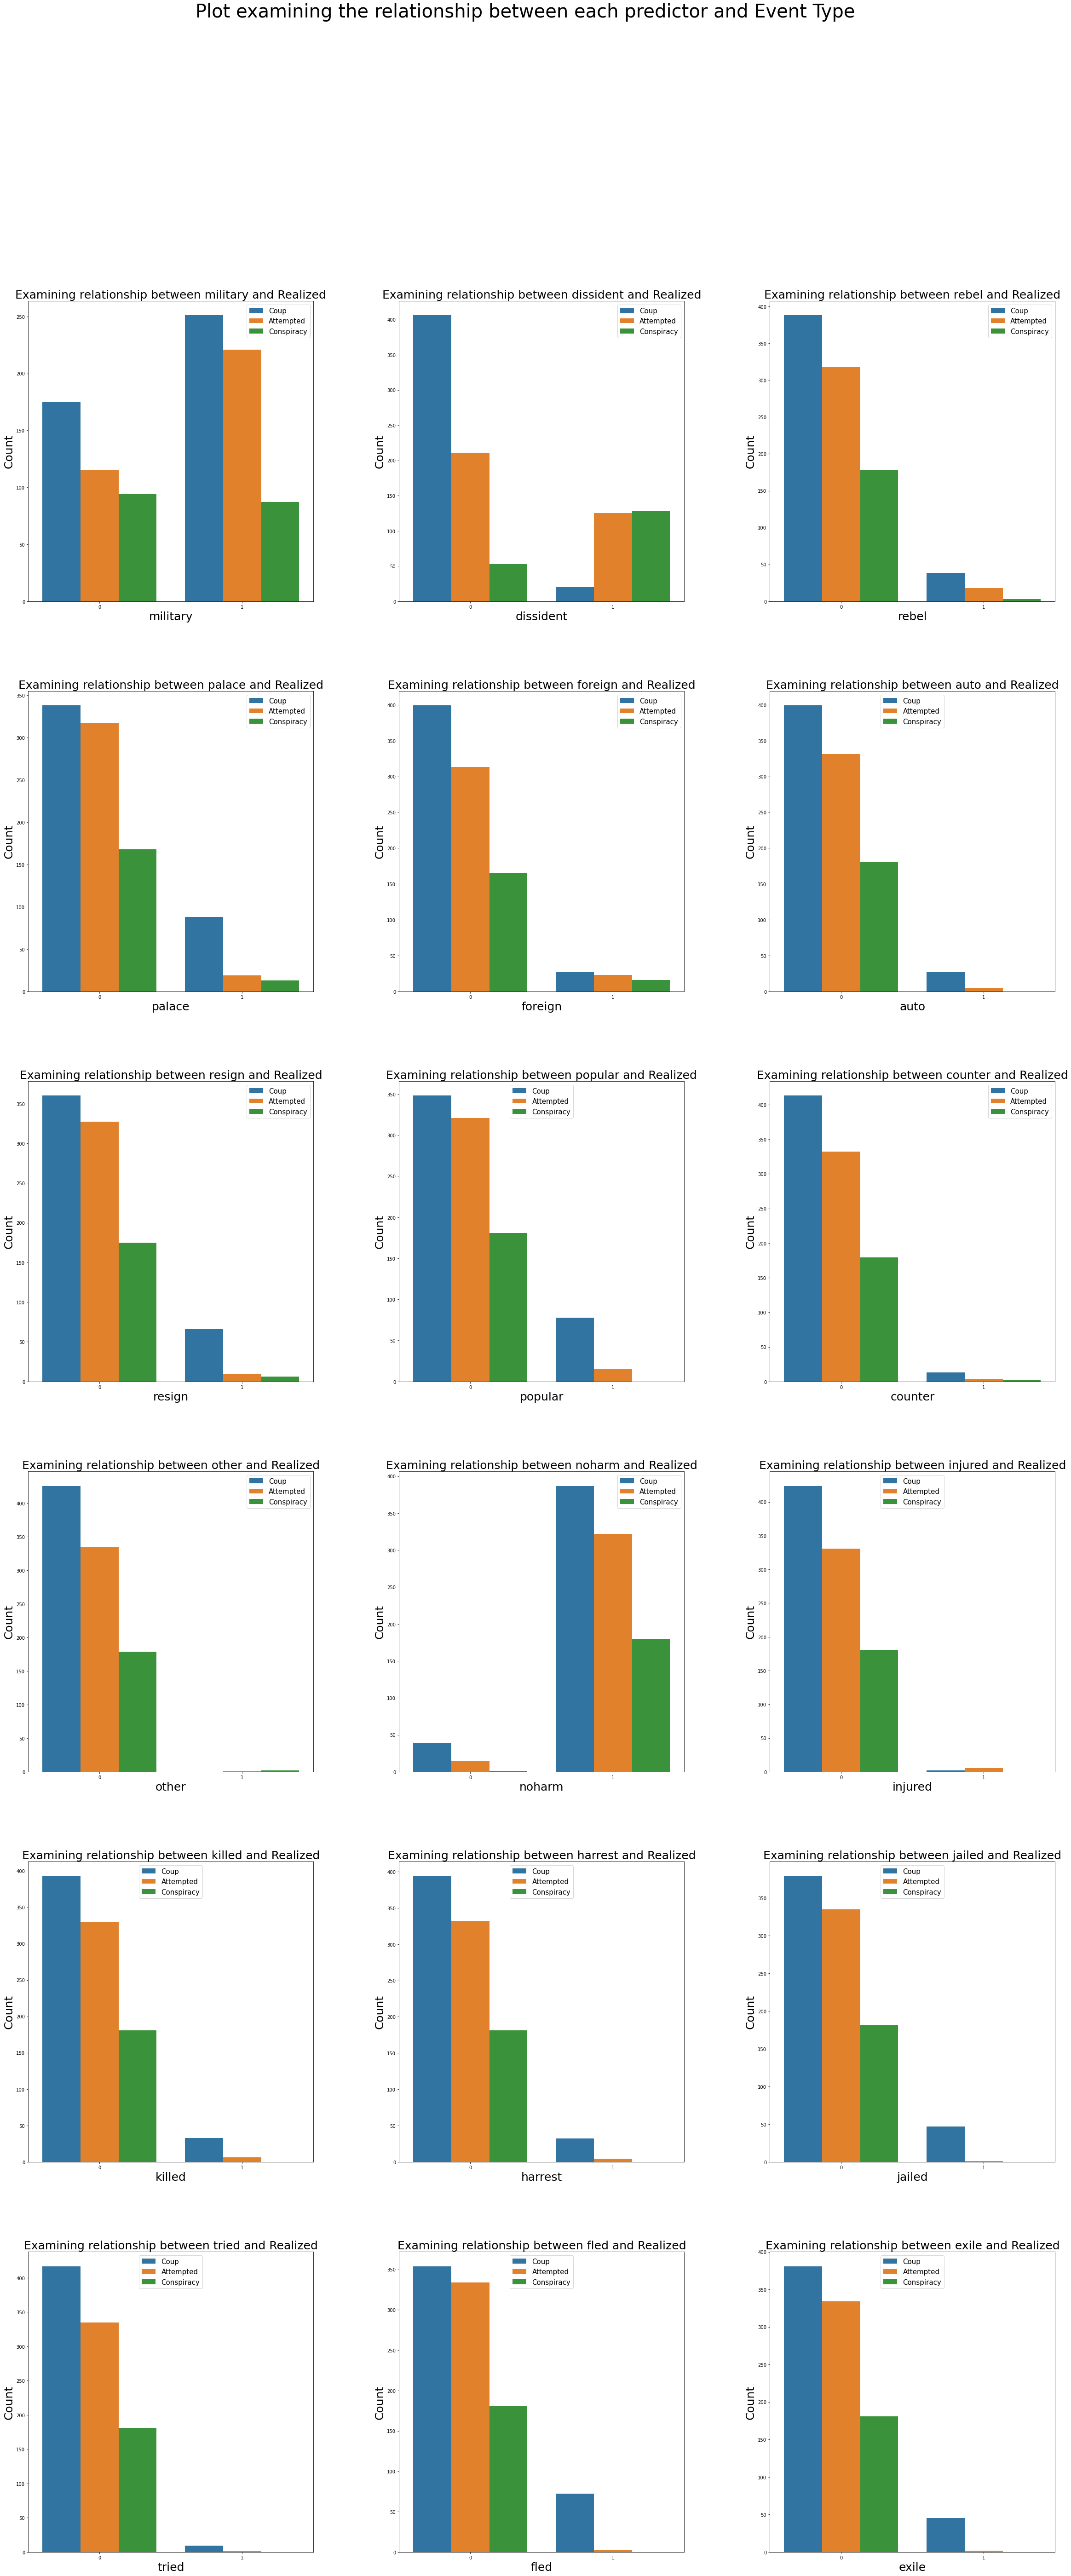

In [13]:
fig, axs = plt.subplots(6,3, figsize = (40, 90))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
axs = axs.flatten()

response = coup_df['event_type']
predictors = ["country","year","month","day","military","dissident","rebel",
"palace","foreign","auto","resign","popular","counter","other","noharm","injured","killed","harrest"
,"jailed","tried","fled","exile"]

#this doesn't include country and year. Will do seperate LARGE plot for those
plt.suptitle("Plot examining the relationship between each predictor and Event Type", fontsize = 40)

for i in range(0,18):
    pred = predictors[i+4]
    ax = sns.countplot(ax=axs[i], x=predictors[i+4], hue=response, data=coup_df)
    axs[i].set_title(f"Examining relationship between {pred} and Realized", fontsize = 25)
    axs[i].set_ylabel("Count", fontsize = 25)
    axs[i].set_xlabel(f"{pred}", fontsize = 25)
    axs[i].legend(["Coup", "Attempted", "Conspiracy"], fontsize =15)




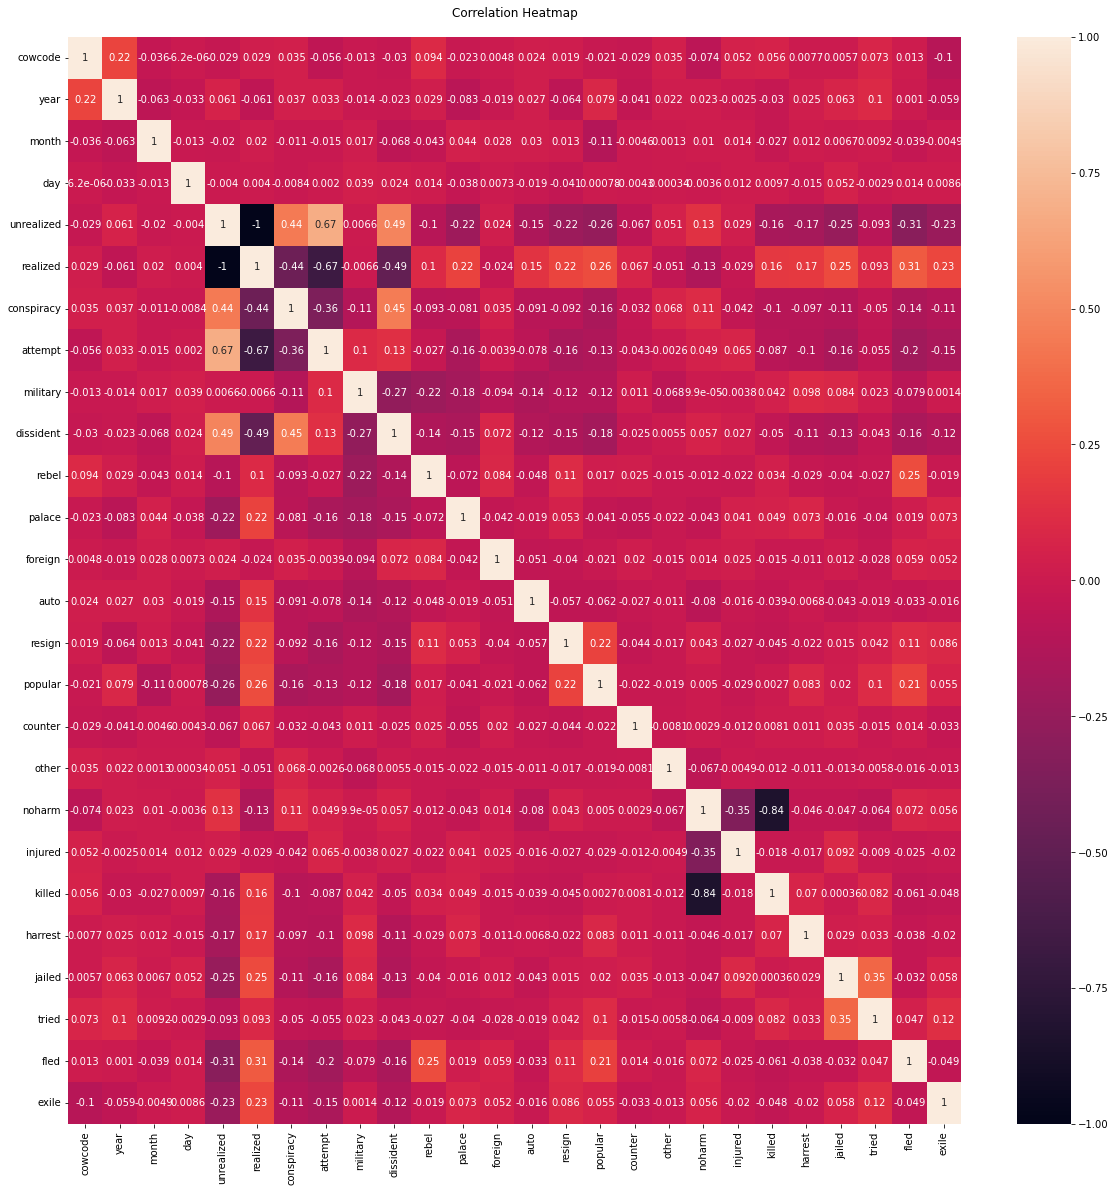

In [14]:
# Correlation between different variables
correlation_matrix = coup_df.corr()

# Increase the size of the heatmap.
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=20);

In [15]:
#### Correlation Check 
greater = [f'{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]} have correlation {round(correlation_matrix.iloc[i,j], 5)}' for i, j in zip(*np.where(correlation_matrix.values > .99)) if i > j]
lower = [f'{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]} have correlation {round(correlation_matrix.iloc[i,j], 5)}' for i, j in zip(*np.where(correlation_matrix.values < - .99)) if i > j]
print("Correlations greater than 0.99")
for i, sen in enumerate(greater): 
    print(i+1, '-', sen)
print("")
print("Correlations less than -0.99")
for i, sen in enumerate(lower): 
    print(i+1, '-', sen)

correlation_matrix = coup_df.corr()
greater = [f'{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]} have correlation {round(correlation_matrix.iloc[i,j], 5)}' for i, j in zip(*np.where(correlation_matrix.values > .60)) if i > j]
lower = [f'{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]} have correlation {round(correlation_matrix.iloc[i,j], 5)}' for i, j in zip(*np.where(correlation_matrix.values < - .60)) if i > j]
print("")
print("Correlations greater than 0.30")
for i, sen in enumerate(greater): 
    print(i+1, '-', sen)
print("")
print("Correlations less than -0.30")
for i, sen in enumerate(lower): 
    print(i+1, '-', sen)

Correlations greater than 0.99

Correlations less than -0.99
1 - realized and unrealized have correlation -1.0

Correlations greater than 0.30
1 - attempt and unrealized have correlation 0.6738

Correlations less than -0.30
1 - realized and unrealized have correlation -1.0
2 - attempt and realized have correlation -0.6738
3 - killed and noharm have correlation -0.84276


## Findings 

From the graphs, you can see that some variables such as (auto, exile, flex) are skewed towards the lack of presence (0). These variables could potentially introduce correlation or problems with predicting our response variable. We will continue to explore and look at these variables as to how they might impact our dataset and model. We imagine that variables from auto onwards (referring to the list above) expose the model to whether or not a coup will be realized or unrealized. 


# Model selection:

In this section we are trying to answer the question of: what are the relevant variables? What are the relevant variables to predict the success (`realized` variable) of a coup?

We will try to use Lasso as also our own understanding of the variables for which are best to select or not. 
The questions we will answer here are: ccording to lasso, which variables are more relevant to predict the success of a coup or not? Do we agree with this selection?

### Lasso

To aid our model-selection process, we will use Lasso. Lasso (L1 penalization) can be used as model selection instrument, because it's penalization term can send predictor coefficients to 0. 

$$ L1 = \lambda \sum_{j=0}^{M}|W_j|$$

The predictors' coefficients that are 0 show that those predictors are not significant, according to lasso, thereby doing model selection. 

### Variables pre-selection before applying Lasso

Before even doing my model selection with Lasso, I am dropping:

- `country`: because it is a string, and because the `cowcode` already includes this information where each country has a code
- `coup_id`: because it is a code, it is a unique string id to each single different coup
- `event_type`: because it is already included in the columns `unrealised`, `realised`, `conspiracy`, `attempt`
- `unrealised`: because it is the opposite of realised. Unrealised is a perfect linear combination of the `realised` column. Consequently, they both explain the same. Which means that including this in my x matrix as a predictor would be 'cheating' in my prediction. Hence this will be dropped. Additionally, see perfect linear correlation between realised and unrealized in the correlation matrix below.

Additionally, we will drop:
- `attempt` 
- `conspiracy` 

We remove the  `attempt` and `conspiracy` predictors, because they are a linear combination with the predictor y. Being that the predictor `unrealised` is a perfect linear combination of the predictor `realised`, and that the predictor `unrealised` expresses the conspiracies and the attempts, we are dropping `attempt` and `conspiracy` predictors, to ensure we are avoiding **collinearity**. If we kept them in our analysis, the prediction would be nearly perfect, as these already give away the answer whether a coup was successful or not. 

See the correlation matrix below. `unrealized` has 0.4 correlation with  `conspiracy` and 0.6 correlation with `attempt`. Hence, if we dropped `unrealized`, we also should have dropped `conspiracy` and `attempt`, as they are all correlated and they all explain the same.




In [16]:
coup_df.corr()

,cowcode,year,month,day,unrealized,realized,conspiracy,attempt,military,dissident,...,counter,other,noharm,injured,killed,harrest,jailed,tried,fled,exile
cowcode,1.000000,0.219607,-0.036307,-0.000006,-0.029497,0.029497,0.035189,-0.056172,-0.012795,-0.029959,...,-0.029484,0.034915,-0.074084,0.052356,0.055911,0.007654,0.005674,0.072603,0.013239,-0.099683
year,0.219607,1.000000,-0.063125,-0.033224,0.061064,-0.061064,0.037107,0.032511,-0.014273,-0.022681,...,-0.041230,0.022139,0.023389,-0.002502,-0.029821,0.025119,0.062784,0.099818,0.001007,-0.059096
month,-0.036307,-0.063125,1.000000,-0.012632,-0.020131,0.020131,-0.010843,-0.015427,0.017322,-0.067967,...,-0.004603,0.001291,0.009963,0.013701,-0.027098,0.012430,0.006664,0.009243,-0.038618,-0.004942
day,-0.000006,-0.033224,-0.012632,1.000000,-0.004022,0.004022,-0.008396,0.001957,0.038717,0.024338,...,-0.004288,0.000341,-0.003564,0.011768,0.009738,-0.015171,0.052455,-0.002910,0.014325,0.008590
unrealized,-0.029497,0.061064,-0.020131,-0.004022,1.000000,-1.000000,0.442406,0.673799,0.006627,0.485467,...,-0.066981,0.051281,0.133946,0.028852,-0.164608,-0.174996,-0.245428,-0.093248,-0.305627,-0.232727
realized,0.029497,-0.061064,0.020131,0.004022,-1.000000,1.000000,-0.442406,-0.673799,-0.006627,-0.485467,...,0.066981,-0.051281,-0.133946,-0.028852,0.164608,0.174996,0.245428,0.093248,0.305627,0.232727
conspiracy,0.035189,0.037107,-0.010843,-0.008396,0.442406,-0.442406,1.000000,-0.361770,-0.111226,0.448848,...,-0.031560,0.068098,0.108529,-0.042148,-0.101230,-0.097098,-0.112868,-0.050457,-0.142222,-0.111624
attempt,-0.056172,0.032511,-0.015427,0.001957,0.673799,-0.673799,-0.361770,1.000000,0.101092,0.131994,...,-0.043363,-0.002587,0.049432,0.064876,-0.087408,-0.101630,-0.161820,-0.055216,-0.200130,-0.149642
military,-0.012795,-0.014273,0.017322,0.038717,0.006627,-0.006627,-0.111226,0.101092,1.000000,-0.265705,...,0.011321,-0.068161,0.000099,-0.003760,0.042072,0.097540,0.083922,0.022591,-0.079190,0.001378
dissident,-0.029959,-0.022681,-0.067967,0.024338,0.485467,-0.485467,0.448848,0.131994,-0.265705,1.000000,...,-0.024970,0.005460,0.056688,0.026518,-0.050384,-0.114970,-0.126551,-0.043258,-0.160188,-0.124708


## Exploration of potentially problematic predictors

Based off of the definition of these predictors from the codebook, we think that certain predictors might give away the response. For example, killed has the description "A dummy variable where one indicates the deposed executive was killed during the coup event and zero otherwise." This essentially means that there was a coup because the executive was removed. We plan to create a sub-dataframe to look at only successful coups and see what the means are of these predictors. The mean will show us how prevelant each predictor in relation to success. We plan to remove these predictors in further EDA exploration for this milestone and for creating our baseline model. 

For the final project, we can do deeper analysis of these terms to see how they affect our model or if we can use them for interaction terms. We can even see what happens when we do add these to our model or use other methods to explore what these mean.

List of Potentially problematic predictors and their variables:
- `auto` - A dummy variable where one indicates an auto coup and zero otherwise.
- `resign` - A dummy variable where one indicates a forced resignation and zero otherwise
- `popular` - A dummy variable where one indicates a popular revolt and zero otherwise.
- `counter` - A dummy variable where one indicates a counter-coup and zero otherwise.
- `other` - A dummy variable where one indicates the coup event does not fit into any of the above categories or the actors were not identified and zero otherwise.
- `noharm` - A dummy variable where one indicates the deposed executive was not harmed during the coup event and zero otherwise.
- `injured` - A dummy variable where one indicates the deposed executive was injured during the coup event and zero otherwise.
- `killed` -  A dummy variable where one indicates the deposed executive was killed during the coup event and zero otherwise.
- `harrest` - A dummy variable where one indicates the deposed executive was placed under house arrest and zero otherwise.
- `jailed` -  A dummy variable where one indicates the deposed executive was jailed and zero otherwise.
- `tried` - A dummy variable where one indicates the deposed executive was tried and zero otherwise.
- `fled` - A dummy variable where one indicates the deposed executive fled the country and zero otherwise.
- `exile` - A dummy variable where one indicate the deposed executive was banished from the country and zero otherwise.

#### Problematic predictors to exclude

Realized Coup - A coup that achieves the effective removal or displacement of the targeted incumbent actor, or ends their ability to direct national governance. The plotters need not accomplish the effective takeover of the state apparatus.

This definition from the codebook implies that any variable that discusses what occurred to the executive would mean that a coup was successful because of the use of the word chose "deposed." Deposed implies to us that a targeted actor was removed or emded their abbility to direct a national governance, matching the definition of a success. The list of predictors that are associated with a deposed target are `noharm`, `injured`, `killed`, `harrest`, `jailed`, `tried`, `fled`, `exile`, `resign`. We decided to take an in-depth look at these predictors because we believe that they should always correlate with a realized coup or a response variable of 1. 

When taking a closer look at these variables, we found that noharm is in 94% of all data samples, and almost equally distributed across the unrealized and realized coups at 97% and 90% respectively. The rest of the predictors: `harrest`, `killed`, `resign`, `exile`, `jailed`, `fled`, `tried`, `injured`, we grouped together to analyze how the combination of these reveal the response. We found that the combination of these are present in 58% of successful coups whereas they are only present in 6% of unsuccessful coups. We feel that by revealing 58% of the successes is enough justification for their removal.


In [17]:
success_df = coup_df[coup_df['realized']==1 ]
unsuccess_df = coup_df[coup_df['realized']==0 ]

print("Looking at the presence of noharm across the entire coup_df")
noharm = coup_df['noharm']
noharm_nonzero = np.count_nonzero(noharm)
print("Noharm total length:", len(noharm))
print("Amount of nonzero items in the series: ", noharm_nonzero)
per_noharm = (noharm_nonzero/len(noharm))*100
print("The percent of columns noharm is present (value = 1): ",round(per_noharm,2),"%")
noharm_success = success_df['noharm']
noharm_success_nonzero = np.count_nonzero(noharm_success)
per_success = (noharm_success_nonzero/len(noharm_success))*100
print("The percent of columns noharm is present in successful coups:", round(per_success,2), "%")
noharm_unsuccess = unsuccess_df['noharm']
noharm_unsuccess_nonzero = np.count_nonzero(noharm_unsuccess)
per_unsuccess = (noharm_unsuccess_nonzero/len(noharm_unsuccess))*100
print("The percent of columns noharm is present in unsuccessful coups:", round(per_unsuccess,2), "%")


######################################

problem_df = success_df[['harrest',  'killed','resign'  ,'exile', 'jailed','fled', 'tried',   'injured']]


col_vector = problem_df.sum(axis =1)
non_zeros = np.count_nonzero(col_vector)
print("\n We are creating a masked dataframe to see how certain predictors affect successful coups")
print("Column Vector length for successful coups",len(col_vector))
print("Amount of non zero values in the column vector:",non_zeros)
print("The percent of columns where at least one of the problematic predictors are present")
mean = round(non_zeros/len(col_vector)*100,2)
print("(value = 1) in the success dataframe: ",mean, "%")


#############################################################

problem_df_opp = unsuccess_df[['killed', 'harrest', 'jailed', 'tried', 'fled', 'exile', 'resign', 'injured' ]]

col_vector_un = problem_df_opp.sum(axis =1)
# problem_df_opp.head()
non_zeros_un = np.count_nonzero(col_vector_un)
print("\nWe are creating a masked dataframe to see how certain predictors affect unsuccessful coups")
print("Column Vector length for unsuccessful coups: ",len(col_vector_un))
print("Amount of nonzero terms in above column vector:",non_zeros_un)
print("The percent of columns where at least one of the problematic predictors are present")
mean_un = round(non_zeros_un/len(col_vector_un)*100,3)
print("(value = 1) in the unsuccessful dataframe: ",mean_un,"%")


Looking at the presence of noharm across the entire coup_df
Noharm total length: 943
Amount of nonzero items in the series:  889
The percent of columns noharm is present (value = 1):  94.27 %
The percent of columns noharm is present in successful coups: 90.85 %
The percent of columns noharm is present in unsuccessful coups: 97.1 %

 We are creating a masked dataframe to see how certain predictors affect successful coups
Column Vector length for successful coups 426
Amount of non zero values in the column vector: 249
The percent of columns where at least one of the problematic predictors are present
(value = 1) in the success dataframe:  58.45 %

We are creating a masked dataframe to see how certain predictors affect unsuccessful coups
Column Vector length for unsuccessful coups:  517
Amount of nonzero terms in above column vector: 32
The percent of columns where at least one of the problematic predictors are present
(value = 1) in the unsuccessful dataframe:  6.19 %


# Baseline model 

#### Code structure:

* first, we do train/test split
* then we cross validate to find the best hyper paramenter lambda
* then we apply Lasso and check the coefficients with `.coef_` and check which ones were sent to 0

#### Variables: 

As said above, we will first drop `country`, `coup_id`, `event_type`, `unrealized`, `attempt`, `conspiracy` for the aforementioned reasons. 

Additionally, we want to also drop `harrest`, `killed`, `resign`, `exile`, `jailed`, `fled`, `tried`, `injured` as mentioned above.

In [18]:

to_drop = ['country', 'coup_id', 'event_type', 'unrealized', 'attempt', 'conspiracy', 'harrest',  'killed','resign'  ,'exile', 'jailed','fled', 'tried',   'injured']
coup_df_selected = coup_df.copy()
coup_df_selected = coup_df_selected.drop(columns = to_drop)

y = coup_df_selected['realized']
x = coup_df_selected.drop(columns = 'realized')
predictors_selected = x.columns.values.tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=31)
scores_dictionaries = {}

### Scaling:

Here we are using MinMaxScaler to scale the predictors `cowcode`, `year`, `month`, `day` because otherwise the model with give them more importance, as all the other variables are either 0 or 1.

In [19]:
## remmber to import warning s later
non_binary_predict = ['cowcode', 'year', 'month', 'day' ]
scaler = MinMaxScaler().fit(x_train[non_binary_predict])
x_train[non_binary_predict] = scaler.transform(x_train[non_binary_predict])
x_test[non_binary_predict] = scaler.transform(x_test[non_binary_predict])

In [20]:
logistic = LogisticRegressionCV(penalty = 'l1', solver = 'saga',max_iter = 8000)
logistic.fit(x_train,y_train)
logistic.intercept_
y_pred_test = logistic.predict(x_test)
y_pred_train = logistic.predict(x_train)

train_score = round(accuracy_score(y_train, y_pred_train)*100,3)
test_score = round(accuracy_score(y_test, y_pred_test)*100,3)


print(f"Baseline training score is {train_score:.3f}%")
print(f"Baseline testing score is {test_score:.3f}%")

list_coef_names = x_train.columns.values.tolist()
list_coef = logistic.coef_

scores_dictionaries["Baseline model test score"] = test_score
print(f"The Intercept is {logistic.intercept_[0]}")
print_coefs(zip(list_coef_names, list_coef[0]))

Baseline training score is 75.152%
Baseline testing score is 73.852%
The Intercept is 0.805073769153977
Sorted Positive Coefficients
	rebel                         0.0354
	auto                          0.5027
	palace                        0.9671
	popular                       1.3264
---------------------------------------------
Sorted Negative Coefficients

	dissident                     -2.5343
	year                          -0.4074
	noharm                        -0.3606
	military                      -0.2192


FPR & FNR from our Baseline model using the test data
The calculated false positive rate based off our model: 0.371
The calculated false negative rate based off our model: 0.121


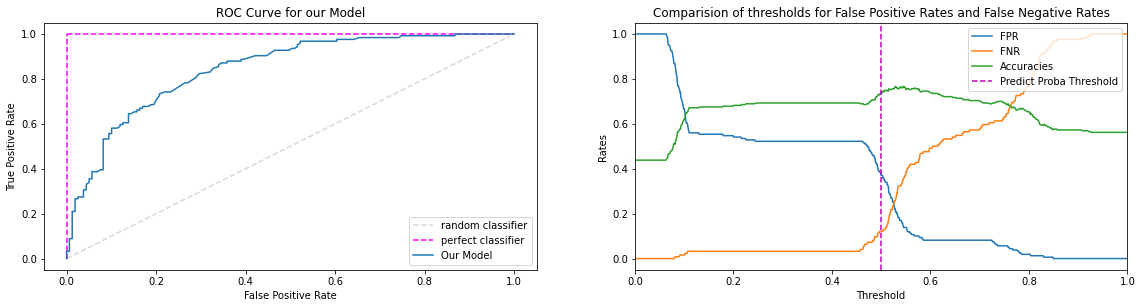

In [21]:
print("FPR & FNR from our Baseline model using the test data")
FPR_log, FNR_log = calculate_rates(y_test,y_pred_test)
yhat = logistic.predict_proba(x_test)[:,1]
rates_plot(y_test,yhat)

# Improved modelling


## Interaction terms


### Two interaction terms

In [22]:
x_train_interactions = x_train.copy()
x_test_interactions = x_test.copy()
combinations = list(itertools.combinations(x_train.columns, 2))

In [23]:
# interaction_colnames = []
i=0
for a, b in combinations:
    clear_output(wait=True)
    colname = '{} {}'.format(a, b)
    
    val_train = x_train[a] * x_train[b]
    if np.all((val_train == 0)) == False:
        x_train_interactions[colname] = val_train
        x_test_interactions[colname] = x_test[a] * x_test[b]
    
    print("Current Progress =", np.round(i/len(combinations) * 100, 2 ), "%")
    i+=1

Current Progress = 98.9 %


In [24]:
x_train_interactions.head()

,cowcode,year,month,day,military,dissident,rebel,palace,foreign,auto,...,palace popular,palace noharm,foreign popular,foreign counter,foreign noharm,auto noharm,popular counter,popular noharm,counter noharm,other noharm
461,0.093882,0.148649,0.636364,0.032258,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165,0.150844,0.445946,0.818182,0.935484,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238,0.746835,0.054054,0.000000,0.677419,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,0.166667,0.243243,0.272727,0.064516,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
850,0.841772,0.175676,0.818182,0.645161,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Three interaction terms

In [25]:
combinations = list(itertools.combinations(x_train.columns, 3))
i = 0
for a, b, c in combinations:
    clear_output(wait=True)
    colname = '{} {} {}'.format(a, b, c)
    val_train = x_train[a] * x_train[b] * x_train[c]
    
    if np.all((val_train == 0)) == False:
        x_train_interactions[colname] = val_train
        x_test_interactions[colname] = x_test[a] * x_test[b] * x_test[c]  
    print("Current Progress =", np.round(i/len(combinations) * 100, 2 ), "%")
    i+=1

Current Progress = 99.73 %


In [26]:
x_train_interactions

,cowcode,year,month,day,military,dissident,rebel,palace,foreign,auto,...,rebel palace noharm,rebel foreign noharm,rebel popular noharm,rebel counter noharm,palace foreign noharm,palace auto noharm,palace popular noharm,foreign popular noharm,foreign counter noharm,popular counter noharm
461,0.093882,0.148649,0.636364,0.032258,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165,0.150844,0.445946,0.818182,0.935484,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238,0.746835,0.054054,0.000000,0.677419,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,0.166667,0.243243,0.272727,0.064516,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
850,0.841772,0.175676,0.818182,0.645161,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,0.831224,0.810811,0.090909,0.032258,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
894,0.525316,0.472973,0.363636,0.387097,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0.453586,0.905405,0.181818,0.709677,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599,0.568565,0.405405,1.000000,0.548387,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## LogisticRegressionCV


In [27]:
logit_lasso_interact_predictors = list(x_train_interactions.columns) 
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
max_iter = 8000
penalty = "l1"
solver = "saga"

logit_lasso_interact = LogisticRegressionCV(random_state = 1, Cs=Cs, cv=10, penalty=penalty, max_iter=max_iter, solver=solver).fit(x_train_interactions.values, y_train.values)

accuracy_train_logit_lasso_interact = round(logit_lasso_interact.score(x_train_interactions.values, y_train)*100, 3)
accuracy_test_logit_lasso_interact = round(logit_lasso_interact.score(x_test_interactions.values, y_test)*100, 3)

print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f} %\n\tTEST\t{:.4f}%"
    .format(accuracy_train_logit_lasso_interact, accuracy_test_logit_lasso_interact))

print()
print(f"The Intercept is {logistic.intercept_[0]}")
print_coefs(zip(logit_lasso_interact_predictors,logit_lasso_interact.coef_[0]))


The classification accuracies for 'logit_lasso_interact' are:

	Train	78.9390 %
	TEST	74.5580%

The Intercept is 0.805073769153977
Sorted Positive Coefficients
	military popular              0.2861
	cowcode month                 0.3391
	day foreign noharm            0.3967
	popular noharm                0.4569
	month military                0.4966
	month auto                    0.5905
	palace noharm                 0.6426
	day military noharm           0.7313
	auto noharm                   0.7364
	month military popular        0.7713
	palace                        0.8193
	cowcode noharm                0.9107
	military counter              1.2571
	military dissident            1.2741
	year rebel                    1.4784
	year popular                  1.6885
---------------------------------------------
Sorted Negative Coefficients

	dissident noharm              -1.7914
	cowcode military noharm       -1.5537
	dissident                     -1.1721
	month dissident noharm        -0.8237

In [28]:

lasso_logit_selected_interaction_terms = []
predictors_interactions = x_train_interactions.columns.values.tolist()
for i, name in enumerate(predictors_interactions):
    if logit_lasso_interact.coef_[0][i] != 0:
        lasso_logit_selected_interaction_terms.append(name)
        
    else:
        pass

lasso_logit_not_selected_interaction_terms = []
predictors_interactions = x_train_interactions.columns.values.tolist()
for i, name in enumerate(predictors_interactions):
    if logit_lasso_interact.coef_[0][i] == 0:
        lasso_logit_not_selected_interaction_terms.append(name)
    else:
        pass

In [29]:
# here we are re-assigning the xtrain and xtest variables 
x_train = x_train_interactions[lasso_logit_selected_interaction_terms]
x_test = x_test_interactions[lasso_logit_selected_interaction_terms]

# Feature Selection
We will use a series of univariate ways to select our best features for our baseline model. These tests include:

- Chi Squared
- Mutual Information Classification

For some of these tests, we will use the sklearn.feature_selection package. We will be doing this on all categorical variables and drop any predictors with string types in the dataset.

### Chi Squared
Chi squared will test the relationship between features for distribution. Chi squares considers the degrees of Freedom and a selected  alpha value to determine whether or not we  reject or accept our hypothesis for independence. Independence of a predictor means it does not depend on the response, which we want to remove in this feature selection. Our null hypothesis is that a predictor and response are independent.

The equation can be seen as: 
$$ \chi = \Sigma Z_i^2 $$ 

where $Zi$ is the standard normal variable.  

$$Z_i = \sum_{j=0}^{N} \frac{(O_j - E_j)^2}{E_j}$$

with $O_i$ as observed values, $E_i$ as expected values, $N$ is the amount of observations. 

Using scikit, we can import the feature selection module that performs the Chi squared calculations for us. The module will return the chi squared statistics and p-values for each feature. We are able to use these statistics to determine what values to keep and drop. The higher the Chi-square value the more dependent the value is on the response, but we must compare the chi value to the chosen associated p value in order to deny or accept our hypothesis. We can also plot the outputted p values to see what the highest p values are. With high p values, the predictor is more likely to be independent of the response and cannot be considered for model training. The returned p value is correlated to each test and tells us the probability of getting a chi-square statistic as large or larger than the ran experiment. If the p value is less than 0.05, we reject our null hypothesis and say that the response and predictor are not independent. This means with p values higher than 0.05 we should drop the predictor.

In [30]:

x = x_train.copy()
y = y_train
columns = x.columns.tolist()

chi_stat, p_val = chi2(x,y)


chi_dict = {}
for i in range(len(columns)):
    chi_dict[columns[i]] = [chi_stat[i], p_val[i]]

chi_df = pd.DataFrame.from_dict(chi_dict, orient = 'index', columns = ['Chi Statistic', 'P value'])
chi_df.sort_values(by = ['Chi Statistic'],ascending = False)

chi_df.dropna(axis = 'index')
# Need to set our threshold at 0.05 or the correct alpha to drop the independent columns
keep_pred = chi_df[chi_df['P value'] < 0.05]
keep_pred

,Chi Statistic,P value
dissident,109.159816,1.497147e-25
palace,28.009777,1.207041e-07
year rebel,4.964668,2.587029e-02
year palace,6.611270,1.013354e-02
year popular,21.860434,2.932178e-06
month auto,8.169828,4.259295e-03
day dissident,58.980650,1.592301e-14
military dissident,30.228683,3.839884e-08
military popular,16.848626,4.048264e-05
military counter,9.035147,2.648377e-03


In [31]:
keep = keep_pred.index.tolist()
print(f"We want to keep {len(keep)} out of {len(x.columns.values.tolist() )} predictors \n")
print(f"Predictors that Chi statistic wants us to keep: {keep}")

We want to keep 17 out of 34 predictors 

Predictors that Chi statistic wants us to keep: ['dissident', 'palace', 'year rebel', 'year palace', 'year popular', 'month auto', 'day dissident', 'military dissident', 'military popular', 'military counter', 'dissident noharm', 'palace noharm', 'auto noharm', 'popular noharm', 'month military popular', 'month dissident noharm', 'day dissident foreign']


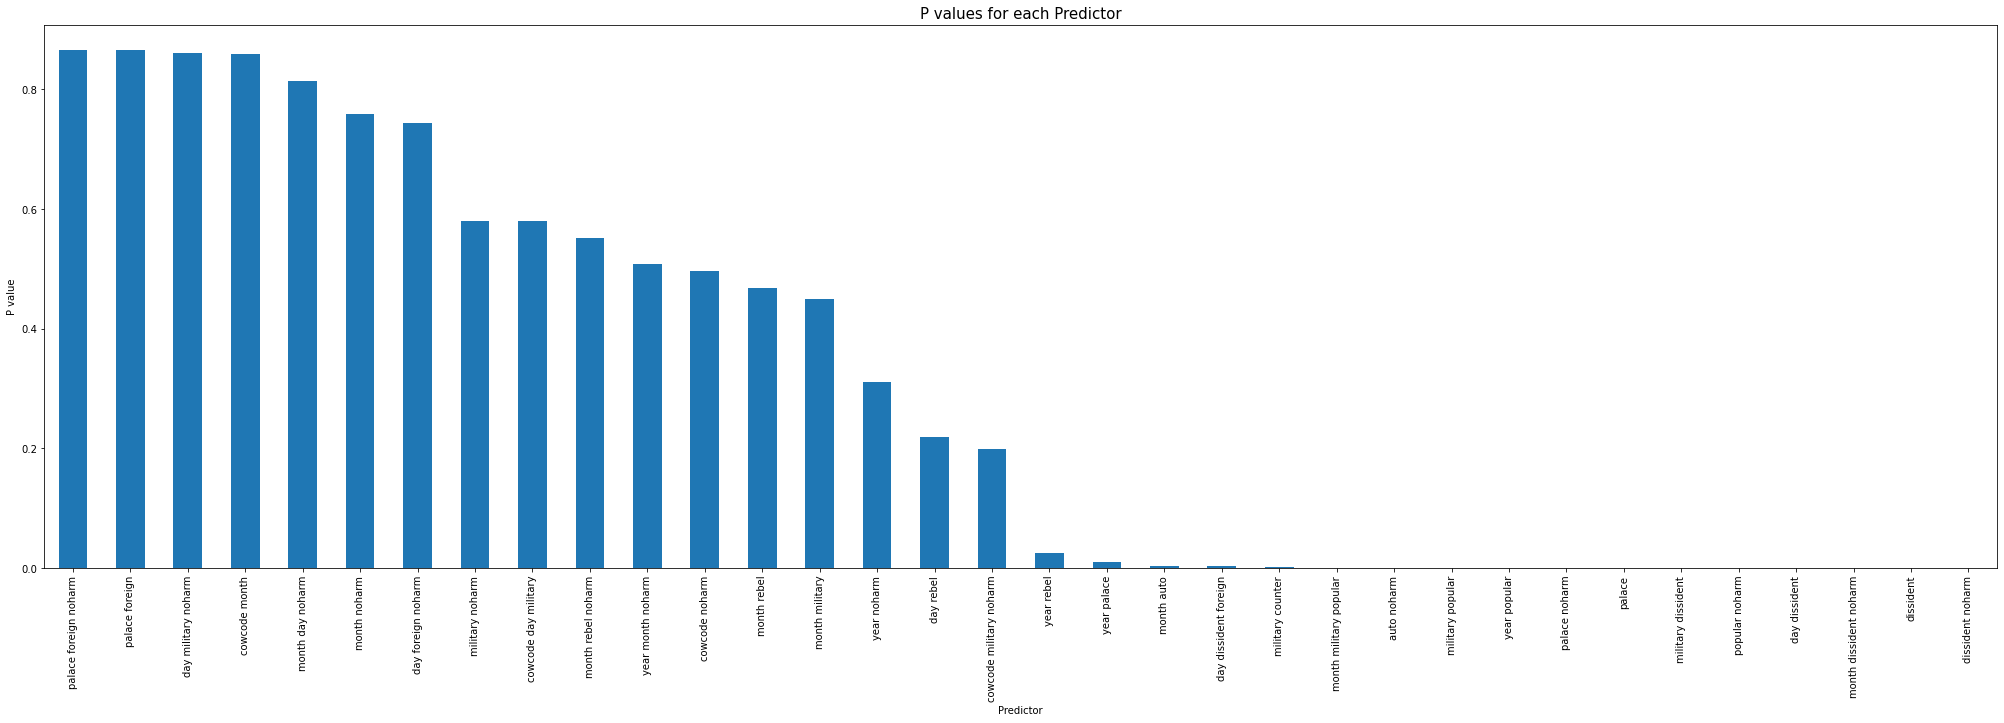

In [32]:
plt.figure(figsize=(35,10))
p_values = pd.Series(p_val,index = columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

plt.title("P values for each Predictor", fontsize = 15)
plt.ylabel("P value")
plt.xlabel("Predictor")
plt.show()

### Mutual Information Classification
This works to determine the dependency two random, categorical, non-negative variables. The outputted statistic will return a zero for independent pairs. The higher the statistic means higher dependency between the variables. This is a package in sklearn.feature_selection and returns mutual information between each feature and the targert. 

In [33]:
x = x_train
y = y_train

mi = mutual_info_classif(x,y, random_state = 50)
#returns resitmated mutual info between each feature & the target
indep = []
dep = []
for i in range(len(columns)):
    if mi[i] == 0.0:
        indep.append(columns[i])
    else: 
        dep.append(columns[i])

In [34]:
print(f"We want to drop {len(indep)} out of {len(x.columns.values.tolist() )} predictors \n")
print(f"Independent terms to drop: {indep}")

We want to drop 9 out of 34 predictors 

Independent terms to drop: ['cowcode month', 'month auto', 'palace foreign', 'popular noharm', 'cowcode day military', 'month day noharm', 'month rebel noharm', 'day dissident foreign', 'day foreign noharm']


In [35]:
print(f"We want to keep {len(dep)} predictors out of {len(x.columns.values.tolist() )} \n")
print(f"Dedependent terms to keep: {dep}")

We want to keep 25 predictors out of 34 

Dedependent terms to keep: ['dissident', 'palace', 'cowcode noharm', 'year rebel', 'year palace', 'year popular', 'year noharm', 'month military', 'month rebel', 'month noharm', 'day dissident', 'day rebel', 'military dissident', 'military popular', 'military counter', 'military noharm', 'dissident noharm', 'palace noharm', 'auto noharm', 'cowcode military noharm', 'year month noharm', 'month military popular', 'month dissident noharm', 'day military noharm', 'palace foreign noharm']


In [36]:
print("We want to find the union between what the Mutual Information and chi statistic tell us to keep")
overall_keep = list(set().union(dep, keep))
print(f"The amount of predictors that are in the union {len(overall_keep)}")
print(overall_keep)

We want to find the union between what the Mutual Information and chi statistic tell us to keep
The amount of predictors that are in the union 28
['palace', 'year noharm', 'dissident noharm', 'military dissident', 'popular noharm', 'month dissident noharm', 'day rebel', 'year popular', 'auto noharm', 'year month noharm', 'cowcode military noharm', 'month military', 'day military noharm', 'military popular', 'day dissident', 'month auto', 'military counter', 'military noharm', 'year rebel', 'cowcode noharm', 'month rebel', 'month military popular', 'day dissident foreign', 'dissident', 'palace noharm', 'month noharm', 'palace foreign noharm', 'year palace']


### Findings & Decisions from initial Feature Selection
We used chi statistic and mutual information classification on the whole set of predictors, including all two way unique interaction terms. We passed them through and were able to get a final union of **28** predictors that either statistic deemed as dependent on the response. While these predictors or interactions

# Modelling after features selection

## 1. Logistic Regression after features selection


In [37]:
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
max_iter = 8000
penalty = "l1"
solver = "saga"

logit_lasso_interact = LogisticRegressionCV(random_state =1, Cs=Cs, cv=10, penalty=penalty, max_iter=max_iter, solver=solver).fit(
    x_train[overall_keep].values, y_train.values)

logit_lasso_interact_coefs = logit_lasso_interact.coef_[0]
logit_lasso_interact_intercept = logit_lasso_interact.intercept_

accuracy_train_logit_lasso_interact = round(logit_lasso_interact.score(x_train[overall_keep].values, y_train)*100, 3)
accuracy_test_logit_lasso_interact = round(logit_lasso_interact.score(x_test[overall_keep].values, y_test)*100, 3)

y_pred_train = logit_lasso_interact.predict(x_train[overall_keep])

print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f} % \n\tTEST\t{:.4f} %"
    .format(accuracy_train_logit_lasso_interact, accuracy_test_logit_lasso_interact)
)
print(
    "The intercept and coefficients for the 'logit_lasso_interact' model are:"
    "\n\n\t{:<30}{:.4f}".format(
        "intercept", logit_lasso_interact_intercept[0]
    )
)
list_coef_names_interactions = x_train[overall_keep].columns.values.tolist()

print_coefs(zip(list_coef_names_interactions,logit_lasso_interact_coefs ))
scores_dictionaries["Logistic Regression after features selection test score"] = accuracy_test_logit_lasso_interact


The classification accuracies for 'logit_lasso_interact' are:

	Train	79.3940 % 
	TEST	74.9120 %
The intercept and coefficients for the 'logit_lasso_interact' model are:

	intercept                     0.5238
Sorted Positive Coefficients
	popular noharm                0.0067
	auto noharm                   0.0727
	palace noharm                 0.5225
	day military noharm           0.7613
	month military                1.0509
	military counter              2.0253
	cowcode noharm                2.2252
	military dissident            2.2309
	year popular                  2.3639
	month auto                    2.4636
	palace                        2.6827
	year rebel                    4.0693
	month military popular        5.2066
---------------------------------------------
Sorted Negative Coefficients

	year palace                   -4.3495
	day dissident foreign         -3.7303
	cowcode military noharm       -3.0211
	dissident noharm              -2.2106
	palace foreign noharm         -2.0

FPR & FNR from our LogisticRegressionCV model using the test data
The calculated false positive rate based off our model: 0.371
The calculated false negative rate based off our model: 0.121


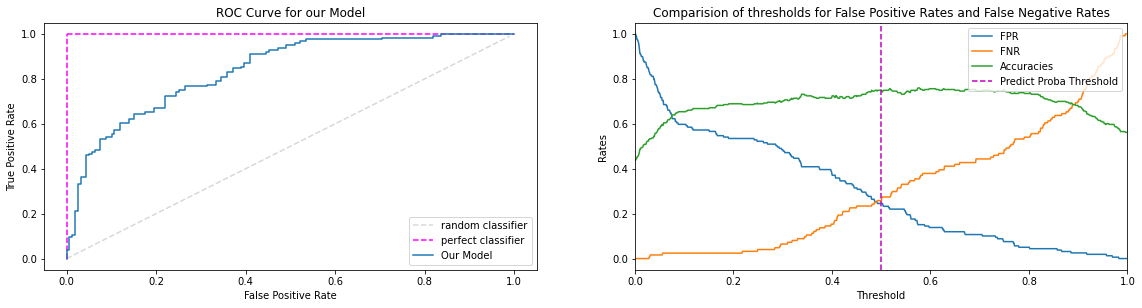

In [38]:
print("FPR & FNR from our LogisticRegressionCV model using the test data")
FPR_log, FNR_log = calculate_rates(y_test,y_pred_test)
yhat = logit_lasso_interact.predict_proba(x_test[overall_keep])[:,1]
rates_plot(y_test,yhat)

### Findings
We see that our model has a higher FNR vs FPR. This means our model is predicting more unrealized coups than there actually was when using the train dataset. From this finding, we want to further improve our model using a Neural Network extension. Our chosen extension is Multi Layer Perceptron Classifier.

## 2. Random Forest

In [39]:
scores_list=[]
cv_scores = []
cvmeans = []
cvstds = []

for i in range(1,29):
    dtree = DecisionTreeClassifier(max_depth=i, random_state = i)
    dtree.fit(x_train[overall_keep], y_train)
    scores_list.append(dtree.score(x_train[overall_keep],y_train))
    cs = cross_val_score(dtree, x_train[overall_keep], y_train, cv = 5) 
    cv_scores.append(cs)
    
for j in cv_scores:
    cvmeans.append(j.mean())
    cvstds.append(j.std())

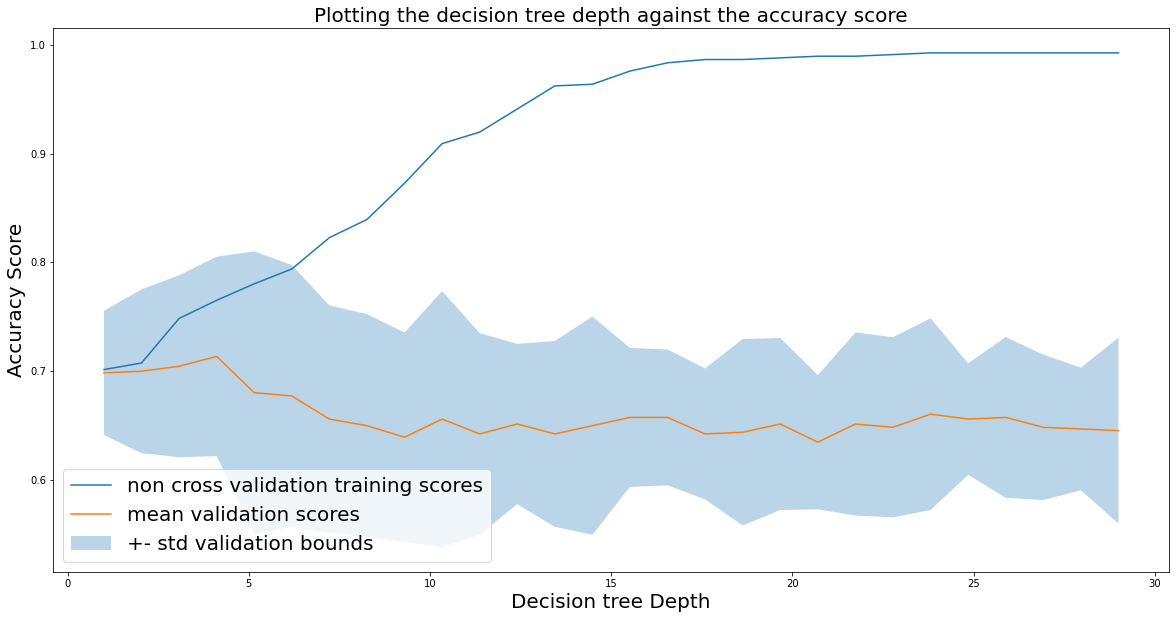

In [40]:
plt.figure(figsize=(20,10))
plt.plot(np.linspace(1,29,28), scores_list, label="non cross validation training scores")
plt.plot(np.linspace(1,29,28), cvmeans, label="mean validation scores")
means_array=np.asarray(cvmeans)
std_array = np.asarray(cvstds)
plt.fill_between(np.linspace(1,29,28), (means_array - 2*std_array) , ( means_array + 2*std_array), label="+- std validation bounds", alpha = 0.3) #fill between 
plt.title("Plotting the decision tree depth against the accuracy score", size = 20)
plt.ylabel("Accuracy Score", size = 20)
plt.xlabel("Decision tree Depth", size = 20)
plt.legend(fontsize = 20)
plt.show()

In [41]:
# the worst depth is the one that minimizes the accuracy cvmeans
lowest_accuracy = min(cvmeans)
worst_depth = cvmeans.index(lowest_accuracy)+1 
print("The worst depth is the depth that minimizes the accuracy, this is the depth of : ", worst_depth,". This depth leads to the accuracy of : ", round(lowest_accuracy*100,3), "%")

new_tree = DecisionTreeClassifier(max_depth=worst_depth, random_state = 50)
new_tree.fit(x_train[overall_keep],y_train)
worst_cv_tree_train_score = round(new_tree.score(x_train[overall_keep], y_train)*100,3)
worst_cv_tree_test_score = round(new_tree.score(x_test[overall_keep], y_test)*100,3)

print(f"The accuracy on the training dataset of the decision tree with the worst depth of {worst_depth} is {worst_cv_tree_train_score}%")
print(f"The accuracy on the testing dataset of the decision tree with the worst depth of {worst_depth} is {worst_cv_tree_test_score}%")

The worst depth is the depth that minimizes the accuracy, this is the depth of :  20 . This depth leads to the accuracy of :  63.485 %
The accuracy on the training dataset of the decision tree with the worst depth of 20 is 98.939%
The accuracy on the testing dataset of the decision tree with the worst depth of 20 is 71.025%


In [42]:

# the best depth is the one that maximises the accuracy cvmeans
highest_accuracy = max(cvmeans)
best_depth = cvmeans.index(highest_accuracy)+1 
print("The best depth is the depth that maximises the accuracy, this is the depth of : ", best_depth,". This depth leads to the accuracy of : ", round(highest_accuracy*100,3), "%")

new_tree = DecisionTreeClassifier(max_depth=best_depth, random_state = 50)
new_tree.fit(x_train[overall_keep],y_train)
best_cv_tree_train_score = round(new_tree.score(x_train[overall_keep], y_train)*100,3)
best_cv_tree_test_score = round(new_tree.score(x_test[overall_keep], y_test)*100,3)

print(f"The accuracy on the training dataset of the decision tree with the best depth of {best_depth} is {best_cv_tree_train_score}%")
print(f"The accuracy on the testing dataset of the decision tree with the best depth of {best_depth} is {best_cv_tree_test_score}%")



The best depth is the depth that maximises the accuracy, this is the depth of :  4 . This depth leads to the accuracy of :  71.364 %
The accuracy on the training dataset of the decision tree with the best depth of 4 is 76.515%
The accuracy on the testing dataset of the decision tree with the best depth of 4 is 72.085%


In [43]:

forest = RandomForestClassifier(max_depth = worst_depth, n_estimators = 100, random_state=50)  #number of tree is the number of estimators
forest.fit(x_train[overall_keep], y_train)
#predictions
y_pred_test = forest.predict(x_test[overall_keep])
y_pred_train = forest.predict(x_train[overall_keep])

random_forest_train_score = round(forest.score(x_train[overall_keep], y_train)*100,3)
random_forest_test_score = round(forest.score(x_test[overall_keep], y_test)*100,3)

print(f"The random forest train score is : {random_forest_train_score}%")
print(f"The random forest test score is : {random_forest_test_score}%")

scores_dictionaries[f"Random Forest with 100 trees and depth {worst_depth} test score"] = random_forest_test_score



The random forest train score is : 99.242%
The random forest test score is : 73.498%


FPR & FNR from our Random Forest model using the test data
The calculated false positive rate based off our model: 0.302
The calculated false negative rate based off our model: 0.218


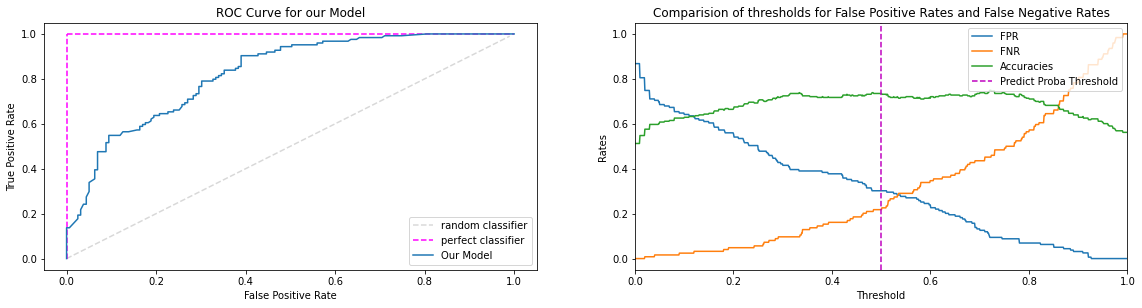

In [44]:
print("FPR & FNR from our Random Forest model using the test data")
FPR_log, FNR_log = calculate_rates(y_test,y_pred_test)
yhat = forest.predict_proba(x_test[overall_keep])[:,1]
rates_plot(y_test,yhat)

In [45]:
count_list_features = []
count_list_features = [0] * len(x_train[overall_keep].columns.values.tolist())
for i in range(len(forest.estimators_)):
    for j in range(len(count_list_features)):
        forest.estimators_[j].tree_.feature[0]
        if forest.estimators_[i].tree_.feature[0] == j:
            count_list_features[j] +=1

In [46]:
count_features = pd.DataFrame()
count_features['predictors'] = x_train[overall_keep].columns.values.tolist()
count_features['how many times this feature was the top node in Random forest'] = count_list_features

sorted_count = count_features.sort_values(by='how many times this feature was the top node in Random forest', ascending=False)
sorted_count

,predictors,how many times this feature was the top node in Random forest
14,day dissident,20
7,year popular,14
23,dissident,13
2,dissident noharm,12
5,month dissident noharm,11
3,military dissident,7
27,year palace,5
24,palace noharm,4
4,popular noharm,4
0,palace,3


## 3. 209 Part:Multi Layer Perceptron 



The advantages of Multi-layer Perceptron are:

- Capability to learn non-linear models.
- Capability to learn models in real-time (on-line learning) using partial_fit.

The disadvantages of Multi-layer Perceptron (MLP) include:

- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.
- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
- MLP is sensitive to feature scaling.


#### What to fine tune with GridSearchCV

We want to fine tune the: iterations number, layers numbers, hidden neurons per hidden layer.




In [47]:
mlp = MLPClassifier(random_state = 1, activation = 'logistic', 
                    solver = 'adam', max_iter = 1000)
                    #early_stopping = True, max_iter = 10000)

parameter_space = {
    'hidden_layer_sizes': [(100, ), (200, ), (150, 150), (100, 100, ), (50, 50, 50),   (300, ), (400, ), (400, 400),  (500, ), (600, ), (1000, ), 
                         (50,100,50), (300, 200, 100), (400, 300, ), (100, 200, 300, ), (500, 400)],
    #'alpha': [0.0001, 0.05],
    #'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=10)
clf.fit(x_train[overall_keep], y_train)


# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results ### VALIDATION SCORES
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r " % (mean, std * 2, params))
    
    
    

Best parameters found:
 {'hidden_layer_sizes': (1000,)}
0.768 (+/-0.125) for {'hidden_layer_sizes': (100,)} 
0.767 (+/-0.132) for {'hidden_layer_sizes': (200,)} 
0.756 (+/-0.132) for {'hidden_layer_sizes': (150, 150)} 
0.768 (+/-0.124) for {'hidden_layer_sizes': (100, 100)} 
0.768 (+/-0.131) for {'hidden_layer_sizes': (50, 50, 50)} 
0.768 (+/-0.119) for {'hidden_layer_sizes': (300,)} 
0.768 (+/-0.129) for {'hidden_layer_sizes': (400,)} 
0.752 (+/-0.125) for {'hidden_layer_sizes': (400, 400)} 
0.758 (+/-0.121) for {'hidden_layer_sizes': (500,)} 
0.758 (+/-0.121) for {'hidden_layer_sizes': (600,)} 
0.770 (+/-0.137) for {'hidden_layer_sizes': (1000,)} 
0.762 (+/-0.121) for {'hidden_layer_sizes': (50, 100, 50)} 
0.750 (+/-0.149) for {'hidden_layer_sizes': (300, 200, 100)} 
0.739 (+/-0.123) for {'hidden_layer_sizes': (400, 300)} 
0.735 (+/-0.177) for {'hidden_layer_sizes': (100, 200, 300)} 
0.762 (+/-0.121) for {'hidden_layer_sizes': (500, 400)} 


In [48]:

mlp = MLPClassifier(random_state = 1, learning_rate = 'adaptive',  hidden_layer_sizes = (300, ), 
                    activation = 'logistic',  max_iter= 1000, solver = 'adam')
mlp.fit(x_train[overall_keep], y_train)

y_pred = mlp.predict(x_test[overall_keep])
y_pred_train = mlp.predict(x_train[overall_keep])
train_score_mlp = round(mlp.score(x_train[overall_keep], y_train)*100, 3)
test_score_mlp = round(mlp.score(x_test[overall_keep], y_test)*100,3)
print(f"Train score {train_score_mlp:.4f}%")
print(f"test score {test_score_mlp:.4f}%")
scores_dictionaries['MLP after fine tuned score test'] = test_score_mlp

Train score 77.5760%
test score 75.9720%


In [49]:
print(f" Although we select the iterations to be 1000, ADAM needs only {mlp.n_iter_} to reach the minimum loss of {round(mlp.best_loss_,3)}")

 Although we select the iterations to be 1000, ADAM needs only 260 to reach the minimum loss of 0.447


In [50]:
scores_dictionaries

{'Baseline model test score': 73.852,
 'Logistic Regression after features selection test score': 74.912,
 'Random Forest with 100 trees and depth 20 test score': 73.498,
 'MLP after fine tuned score test': 75.972}

### Comparing solvers

In [51]:
mlp_sgd = MLPClassifier(random_state = 1,  hidden_layer_sizes = (300, ), 
                    activation = 'logistic',  max_iter= 1000, solver = 'sgd')
mlp_sgd.fit(x_train[overall_keep], y_train)



MLPClassifier(activation='logistic', hidden_layer_sizes=(300,), max_iter=1000,
              random_state=1, solver='sgd')

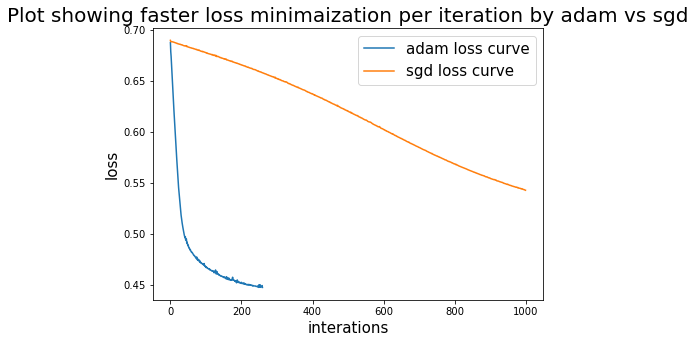

In [52]:
plt.figure(figsize = (7, 5))
plt.plot(mlp.loss_curve_, label = "adam loss curve")
plt.plot(mlp_sgd.loss_curve_, label = "sgd loss curve")
plt.title("Plot showing faster loss minimaization per iteration by adam vs sgd",  size = 20)
plt.xlabel('interations', fontsize = 15)
plt.ylabel('loss', size = 15)
plt.legend(fontsize = 15)
plt.show()

###  Estimating our False Positive and False Negative Rates with MLP



False Positive and Negative Rates from MLP Model using test data
The calculated false positive rate based off our model: 0.189
The calculated false negative rate based off our model: 0.306


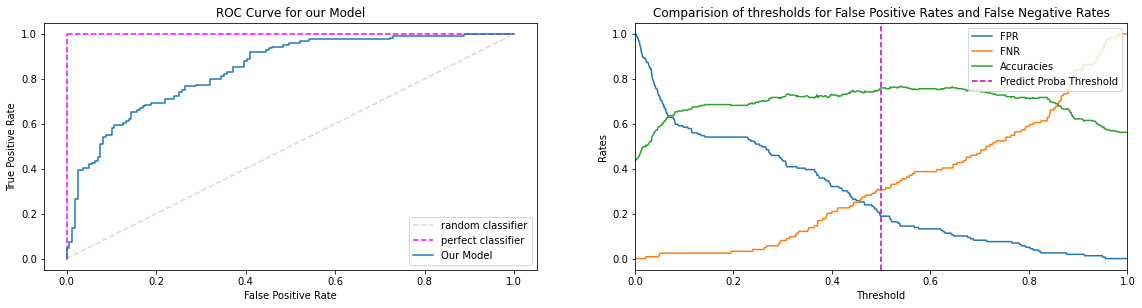

In [53]:
yhat= mlp.predict_proba(x_test[overall_keep])[:,1]
print("False Positive and Negative Rates from MLP Model using test data")
FPR_log, FNR_log = calculate_rates(y_test,y_pred)
rates_plot(y_test,yhat)

# Extension Questions
This notebook will be used to explore extension questions that diverge from our main one of "What makes a coup successful?." We will be exploring different geographic sub-regions and determining if there could be differences in how a coup succeeds or fails. For example, is a coup more likely to be realized in Africa when their is a military force president? Or does it matter more if there was a palace? How does this compare to a country in Asia? Or in Latin America? Another exploration will include how coups have changed throughout time. As modern warfare has changed with technology, has how coups succeed also change? Could there be differences between timeframes where decolonization happened? These questions we have in mind will guide us through these explorations.

## Initial Predictor Selection 
Similar to how we dropped a list of problematic predictors in the main juptyer notebook for revealing the response `realized`, we will also drop them here. That list includes: unrealized, attempt, conspiracy, resign, killed, jailed, tried, fled, exile and harrest. We will also drop event_type and coup_id because they are strings. 

**Note** we will create an extra column called stand_year so that we are able to standardize the years while also keeping the original year predictor for interpretablitty.

**Note** We are starting over with the dataframe rather than using the one prior because we need to keep country and year as ways to identify our sub regions and time frames.


In [54]:
coup_df = pd.read_csv('Coupdata.csv')
coup_df['stand_year'] = coup_df.loc[:, 'year']
coup_selected = coup_df.drop(columns = ['coup_id', 'event_type', 'unrealized', 'attempt', 'conspiracy', 'resign', 'killed', 'jailed', 'tried', 'fled', 'exile', 'harrest'])

coup_selected.head()

,cowcode,country,year,month,day,realized,military,dissident,rebel,palace,foreign,auto,popular,counter,other,noharm,injured,stand_year
0,439,Burkina Faso,2014,10,30,1,1,0,0,0,0,0,1,0,0,1,0,2014
1,516,Burundi,2015,5,13,0,1,0,0,0,0,0,0,0,0,1,0,2015
2,483,Chad,2006,4,13,0,0,1,0,0,0,0,0,0,0,1,0,2006
3,651,Egypt,2011,2,11,1,1,0,0,0,0,0,1,0,0,1,0,2011
4,651,Egypt,2013,7,3,1,1,0,0,0,0,0,0,0,0,1,0,2013


# Exploration of Potential Interests
Here we are looking at potential ways we can assess our data. While our goal is to predict or see what potentially influences the success of a coup overall, we can further break down the data to assess whether there are different predictors that are more important in certain scenarios. For example, we can group our data by geographic region or country or time frames. It could be interesting to see if for certain decades or distinguished time frames what predictors are important to a realized coup and how this can change over time. 

### Exploring the Success of each Country in the data
In this section, we will create a dictionary that will hold the count of the amount of each country's sucessful coups, attempts, conspiracies. This will be called our success dictionary. The data is a dictionary that has the countries name with associated [coups, attempts, conspiracies] values in a list.

Then we will convert the success dictionary into a dataframe and add a column that evaluates a countries success rate. Or the amount of coups over the total amount of coups, attempts, and conspiracies. 

Instead of plotting all the countries and their rates, we are looking at the countries that have the largest values for each column in the dictionary. This can be some of the countries that we decide to look deeper at when seeing what might cause their success in each of the listed columns. This can help us evaluate the information found in our coup dataset. 

In [55]:
success_dict = {}
countries = coup_df.country.unique()

for i in countries:
    success_dict[i] = [0,0,0]

for j in range(len(coup_df)):
    if coup_df.realized[j] == 1:
        success_dict[coup_df.country[j]][0] += 1
    if coup_df.attempt[j] == 1:
        success_dict[coup_df.country[j]][1] += 1
    if coup_df.conspiracy[j] == 1:
        success_dict[coup_df.country[j]][2] += 1


#success_dict 

In [56]:
country_df = pd.DataFrame.from_dict(success_dict, orient = 'index')
columns = country_df.columns = ["Coups", "Attempts", "Conspiracies"]
rate_success = round(country_df['Coups']/(country_df.sum(axis = 1)),2)
country_df["Success_rate"] = rate_success
names = country_df.index
country_df.head()

,Coups,Attempts,Conspiracies,Success_rate
Burkina Faso,8,0,2,0.80
Burundi,8,6,1,0.53
Chad,4,7,3,0.29
Egypt,6,1,6,0.46
Fiji,4,1,0,0.80


In [57]:
country_df = pd.DataFrame.from_dict(success_dict, orient = 'index')
columns = country_df.columns = ["Coups", "Attempts", "Conspiracies"]
rate_success = round(country_df['Coups']/(country_df.sum(axis = 1)),2)
country_df["Success_rate"] = rate_success
names = country_df.index
country_df.head()

,Coups,Attempts,Conspiracies,Success_rate
Burkina Faso,8,0,2,0.80
Burundi,8,6,1,0.53
Chad,4,7,3,0.29
Egypt,6,1,6,0.46
Fiji,4,1,0,0.80


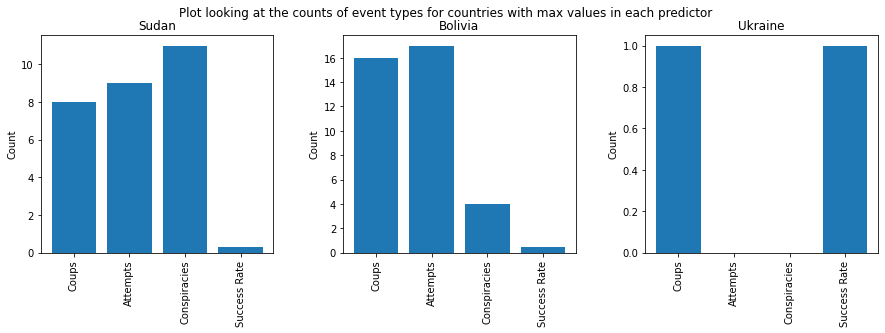

In [58]:
fig, axs = plt.subplots(1,3, figsize = (15, 4))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
axs = axs.flatten()

ind = [0,1,2,3]
countries_plot = ['Sudan', 'Bolivia', 'Ukraine']
plt.suptitle("Plot looking at the counts of event types for countries with max values in each predictor", fontsize = 12)
for i in range(0,3):
    axs[i].bar(ind,country_df.loc[countries_plot[i]])
    axs[i].set_title(countries_plot[i])
    axs[i].set_ylabel("Count")
    axs[i].set_xticklabels(['','Coups', 'Attempts', 'Conspiracies', 'Success Rate'], rotation = 'vertical')

### Now we are going to run a similar process for Year
First, we will create a dictionary to store all the coups, attempts and conspiracies for each year. Then, we will convert it into a panda's data frame to further look at the data and create a success rate. 

In [59]:
year = list(coup_df.year.unique())
year_dict = {}

for i in year:
    year_dict[i] = [0,0,0]

for j in range(len(coup_df)):
    if coup_df.realized[j] == 1:
        year_dict[coup_df.year[j]][0] += 1
    if coup_df.attempt[j] == 1:
        year_dict[coup_df.year[j]][1] += 1
    if coup_df.conspiracy[j] == 1:
        year_dict[coup_df.year[j]][2] += 1

In [60]:
year_df = pd.DataFrame.from_dict(year_dict, orient = 'index')
columns = year_df.columns = ["Coups", "Attempts", "Conspiracies"]
rate_success = round(year_df['Coups']/(year_df.sum(axis = 1)),2)
year_df["Success_rate"] = rate_success
names = year_df.index
year_df.head()

,Coups,Attempts,Conspiracies,Success_rate
2014,3,3,0,0.5
2015,2,1,2,0.4
2006,2,2,6,0.2
2011,2,2,1,0.4
2013,1,3,1,0.2


In [61]:
most_coups_yr = year_df['Coups'].idxmax()
most_attempts_yr = year_df['Attempts'].idxmax()
most_consp_yr = year_df['Conspiracies'].idxmax()
best_rate_yr = year_df['Success_rate'].idxmax()

print(f"Year with most conspiracies at {year_df['Conspiracies'].max()}: ",most_consp_yr) 
print(f"Year with most attempts at {year_df['Attempts'].max()}:", most_attempts_yr) 
print(f"Year with most Coups at {year_df['Coups'].max()}: ", most_coups_yr)
print(f"Year with the best success rate at {year_df['Success_rate'].max()}:", best_rate_yr) 

Year with most conspiracies at 7:  1962
Year with most attempts at 12: 1977
Year with most Coups at 18:  1979
Year with the best success rate at 1.0: 1945


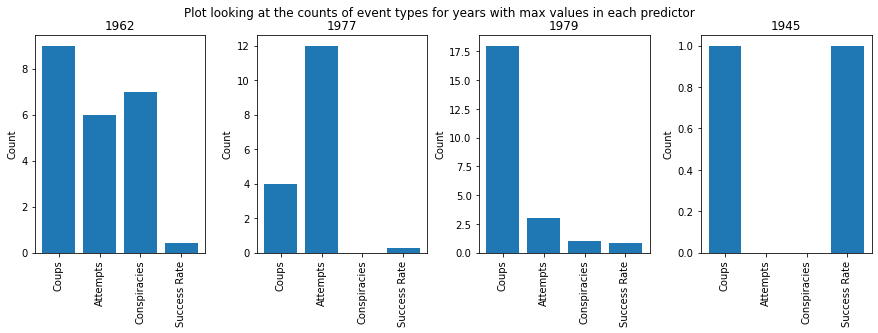

In [62]:
fig, axs = plt.subplots(1,4, figsize = (15, 4))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
axs = axs.flatten()

ind = [0,1,2,3]
year_plot = [1962, 1977, 1979, 1945]
plt.suptitle("Plot looking at the counts of event types for years with max values in each predictor", fontsize = 12)
for i in range(0,4):
    axs[i].bar(ind,year_df.loc[year_plot[i]])
    axs[i].set_title(year_plot[i])
    axs[i].set_ylabel("Count")
    axs[i].set_xticklabels(['','Coups', 'Attempts', 'Conspiracies', 'Success Rate'], rotation = 'vertical')

# Comparision of Sub-Regions
We will be looking at 3 larger sub-regions that have multiple observations to understand what could be making coups successful based on geographic location. These 3 larger regions were chosen in order to avoid any dimensionality issues between using interaction terms and the amount of observations for each dataframe. We acknowledge that the political climates of these sub-regions may not completely align but we want to avoid overfitting and are still able to interpret the outcomes to compare the differences between these regions. These sub-regions will be the Americas (North and Latin America), Africa, and Euro-Asia (includes the Middle East). We will create their sub data frames and see what Lasso considers to be important predictors. We will then be able to analyze the False Positive and False Negative Rates. 

Our decision to use these three groupings was based on the size of our dataset as well as the number of observations that were tied to each of these identified sub-regions. We also grouped them in this way due to geographic spacing. To create these groupings, we found a list of countries from internet resources, and then found the intersection with our country list from the Coup data. 

**Note** We grouped the Carribean with the Americas. While we understand that some of those countries have ethnic ties to other regions, the geographic spacing was our main factor in this decision-making.

It should be noted that Suriname and Ecuador were misspelled as 'Surinam' and 'Ecudaor'. 

In [63]:
america_internet = ['Belize', 'Costa Rica','El Salvador','Guatemala','Honduras','Mexico','Nicaragua', 'Panama', 'Argentina'
, 'Bolivia', 'Brazil', 'Chile', 'Colombia','French Guiana','Guyana', 'Paraguay', 'Peru', 'Jamaica' 
,'Uruguay','Venezuela', 'Cuba', 'Dominican Republic', 'Haiti', 'Guadeloupe', 'Martinique', 'Puerto Rico', 'Saint-Barthélemy'
,'Saint-Martin', 'United States of America', 'Mexico', 'Canada', 'Dominica', 'Surinam', 'Trinidad and Tobago', 'Grenada', 'Ecudaor']

full_country = country_df.index.tolist()

america = list (set(america_internet)& set(full_country))

# need to change this into the interaction term model
america_df = coup_selected[coup_selected.country.isin(america)]
america_df.head() # 247 by 29

,cowcode,country,year,month,day,realized,military,dissident,rebel,palace,foreign,auto,popular,counter,other,noharm,injured,stand_year
11,91,Honduras,2009,6,28,1,1,0,0,1,0,0,0,0,0,1,0,2009
34,101,Venezuela,2019,1,23,0,0,1,0,0,1,0,1,0,0,1,0,2019
35,101,Venezuela,2019,4,30,0,1,1,0,0,1,0,1,0,0,1,0,2019
69,101,Venezuela,2015,2,12,0,1,1,0,0,0,0,0,0,0,1,0,2015
94,160,Argentina,1951,9,28,0,1,0,0,0,0,0,0,0,0,1,0,1951


In [64]:
Africa_internet = ['Algeria','Angola','Benin','Botswana','Burkina Faso','Burundi','Cameroon','Cape Verde'
,'Central African Republic', 'Chad', 'Camoros', 'Democratic Republic of the Congo', 'Republic of the Congo'
, 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia','Ghana', 'Guinea'
, 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi','Mali'
, 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda'
,'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa','South Sudan'
, 'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe', 'Comoros', "Cote d'Ivoire", ]

full_country = country_df.index.tolist()

africa = list (set(Africa_internet)& set(full_country))

# need to change this into the interaction term model
africa_df = coup_selected[coup_selected.country.isin(africa)]
# africa_df.shape (353, 29)
africa_df.head()

,cowcode,country,year,month,day,realized,military,dissident,rebel,palace,foreign,auto,popular,counter,other,noharm,injured,stand_year
0,439,Burkina Faso,2014,10,30,1,1,0,0,0,0,0,1,0,0,1,0,2014
1,516,Burundi,2015,5,13,0,1,0,0,0,0,0,0,0,0,1,0,2015
2,483,Chad,2006,4,13,0,0,1,0,0,0,0,0,0,0,1,0,2006
3,651,Egypt,2011,2,11,1,1,0,0,0,0,0,1,0,0,1,0,2011
4,651,Egypt,2013,7,3,1,1,0,0,0,0,0,0,0,0,1,0,2013


In [65]:
not_eurasia = Africa_internet + america_internet
full_country = country_df.index.tolist()

eurasia = list(set(full_country)- set(not_eurasia))

# need to change this into the interaction term model
eurasia_df = coup_selected[coup_selected.country.isin(eurasia)]

eurasia_df.head() #308, 18


,cowcode,country,year,month,day,realized,military,dissident,rebel,palace,foreign,auto,popular,counter,other,noharm,injured,stand_year
5,950,Fiji,2006,12,5,1,1,0,0,0,0,0,0,0,0,1,0,2006
15,781,Maldives,2012,2,7,1,0,0,0,0,0,0,1,0,0,1,0,2012
20,910,Papua New Guinea,2012,1,26,0,1,0,0,0,0,0,0,0,0,1,0,2012
22,800,Thailand,2006,9,19,1,1,0,0,0,0,0,0,0,0,1,0,2006
23,800,Thailand,2014,5,22,1,1,0,0,0,0,0,0,0,0,1,0,2014


# Scaling, Lasso & LogisticRegressionCV

We created a function that works to take in a dataframe then scales the chosen predictors using MinMaxScaler. From there it will split the data into the appropriate train and test dataframes and fit a LogisticRegressionCV model on the train. From that model, we are able to output the accuracies and the coefficient values for each predictor. We will also be able to compute the False Positive and False Negative rates from this function. This can be used for all of the sub-region and timeframes that we are investigating.

In [66]:

def outputs(df, regions=True):
    '''
    From passing the dataframe, and model, this function will split the dataframe into test and train splits
    and then print out the accuracy scores for test and train based on the passed. It will also print out 
    of the coefficients that are not zero. Lastly, it will print out the false positive and false negative 
    rates. The function returns the list of predictors that should be kept or ones with nonzero coefficients. 
    It will also return the accuracy score.

    If we are passing a dataframe that is looking at a time frame, we use regions = False. 
    This is because we have chosen to use different interaction terms when creating these new 
    dataframes. We do this because we want to use year as an interaction when looking at sub-
    regions, and we want to use cowcodes for timeframes.
    '''
    #Subregions - drop cowcode country and year that is not standaradized 
    if regions: 
        x = df.drop(columns = ['cowcode', 'country', 'year', 'realized']) 
        non_binary_predict = ['stand_year', 'month', 'day']

    # For timeframe - drop country, year and std year (keep std cowcode)
    else: 
        x = df.drop(columns = ['country', 'year', 'stand_year', 'realized'])
        non_binary_predict = ['cowcode', 'month', 'day']
    y = df['realized']

    # Train and test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, train_size=0.7, random_state=31)

    # Scaling 
    scaler = MinMaxScaler().fit(x_train[non_binary_predict])
    x_train[non_binary_predict] = scaler.transform(x_train[non_binary_predict])
    x_test[non_binary_predict] = scaler.transform(x_test[non_binary_predict])

    # Get Interaction terms
    x_train_interactions = x_train.copy()
    x_test_interactions = x_test.copy()

    # 2 interaction terms 
    combinations = list(itertools.combinations(x_train.columns, 2))
    for a, b in combinations:
        colname = '{} {}'.format(a, b)
        val_train = x_train[a] * x_train[b]
        if np.all((val_train == 0)) == False:
            x_train_interactions[colname] = val_train
            x_test_interactions[colname] = x_test[a] * x_test[b]
    
    # 3 Interaction terms
    combinations = list(itertools.combinations(x_train.columns, 3) )
    for a, b, c in combinations:
        colname = '{} {} {}'.format(a, b, c)
        val_train = x_train[a] * x_train[b] * x_train[c]
        if np.all((val_train == 0)) == False:
            x_train_interactions[colname] = val_train
            x_test_interactions[colname] = x_test[a] * x_test[b] * x_test[c]


    Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    max_iter = 8000
    penalty = "l1"
    solver = "saga"

     ## Find most important coefs 
    model = LogisticRegressionCV(Cs=Cs, cv=10, penalty=penalty, max_iter=max_iter, solver=solver).fit(
    x_train_interactions.values, y_train.values)
    model_coefs = model.coef_[0]
    model_intercept = model.intercept_

    # Creating the accuracy scores scores
    accuracy_train = round((model.score(x_train_interactions.values, y_train))*100,3)
    accuracy_test = round((model.score(x_test_interactions.values, y_test))*100,3)
    print(f"Accuracy score from train data: {accuracy_train}%")
    print(f"Accuracy score from test data: {accuracy_test}%")

    # Separate negatives and positives
    positives, negatives, keep_list = [], [], []
    for predictor, coef in zip(list(x_train_interactions.columns), model_coefs):
        if coef > 0.0000: 
            positives.append((predictor, coef))
            keep_list.append((predictor, coef))
        if coef < 0.0000:
            negatives.append((predictor, coef))
            keep_list.append((predictor, coef))
            

    # Sort 
    positives.sort(key=lambda x:x[1])
    negatives.sort(key=lambda x:x[1])

    # Print coefs 
    print("\n Sorted Positive Coefficients ")
    print("")
    for predictor, coef in positives:
        print("\t{:<30}{:.4f}".format(predictor, coef))
    print("---------------------------------------------")
    print("Sorted Negative Coefficients")
    print("")
    for predictor, coef in negatives:
        print("\t{:<30}{:.4f}".format(predictor, coef))

    y_pred = model.predict(x_test_interactions.values)
    FP = ((y_pred == 1 )&(y_test == 0)).sum()
    all_neg = (y_test == 0).sum()
    FPR = FP/all_neg
    

    #FN
    FN = ((y_pred == 0 )&(y_test == 1)).sum()
    all_pos = (y_test == 1).sum()
    FNR = FN/all_pos

    return keep_list, accuracy_test, FPR, FNR

In [67]:
print("America dataframe \n")

America_outputs = outputs(america_df, regions=True)

America dataframe 

Accuracy score from train data: 78.977%
Accuracy score from test data: 64.474%

 Sorted Positive Coefficients 

	day military                  0.2510
	military dissident            0.4104
	counter                       0.9346
	counter noharm                0.9346
	auto                          1.4357
	popular                       2.2054
	palace                        2.3408
---------------------------------------------
Sorted Negative Coefficients

	dissident noharm              -2.5376
	month dissident noharm        -0.7352
	military noharm               -0.0959
	noharm                        -0.0758
	month noharm                  -0.0092


In [68]:
print("Africa dataframe: \n")
AF_outputs = outputs(africa_df, regions=True)

Africa dataframe: 

Accuracy score from train data: 74.708%
Accuracy score from test data: 74.775%

 Sorted Positive Coefficients 

	month day military            0.0343
	palace noharm                 0.1111
	auto noharm                   0.1974
	popular                       0.9885
	military counter              1.2011
	military popular              1.3788
---------------------------------------------
Sorted Negative Coefficients

	dissident noharm              -2.6366
	day dissident noharm          -0.8953
	military noharm               -0.4402
	military noharm stand_year    -0.3943
	noharm                        -0.3507
	noharm stand_year             -0.1648


In [69]:
print("Eurasia dataframe: \n")
EA_outputs = outputs(eurasia_df, regions=True)

Eurasia dataframe: 

Accuracy score from train data: 85.841%
Accuracy score from test data: 63.918%

 Sorted Positive Coefficients 

	day noharm                    0.0307
	month popular noharm          0.1939
	palace popular                0.2055
	palace popular noharm         0.2055
	month popular                 0.2182
	month military dissident      0.3760
	month day                     0.4224
	popular noharm stand_year     0.5535
	popular stand_year            0.6137
	palace                        0.6178
	military                      0.6188
	noharm                        0.6795
	month day stand_year          0.6919
	month day military            0.8220
	day rebel noharm              1.2312
	day foreign                   1.2895
	day foreign noharm            1.2895
	military palace               1.3008
	month military                1.3145
	military popular noharm       1.3789
	rebel noharm                  1.4378
	military counter              1.4874
	military counter noharm       

In [70]:

rates = PrettyTable()
rates.field_names = ["Region", "FPR", "FNR"]
rates.add_row(["Americas", round(America_outputs[2],3), round(America_outputs[3],3)])
rates.add_row(["Africa", round(AF_outputs[2],3), round(AF_outputs[3],3)])
rates.add_row(["Eurasia", round(EA_outputs[2],3), round(EA_outputs[3],3)])
print("False Positive Rates & False Negative Rates for each Sub-Region")
print(rates)

False Positive Rates & False Negative Rates for each Sub-Region
+----------+-------+-------+
|  Region  |  FPR  |  FNR  |
+----------+-------+-------+
| Americas | 0.103 | 0.622 |
|  Africa  | 0.264 | 0.231 |
| Eurasia  |  0.32 | 0.404 |
+----------+-------+-------+


## Visualization & Analysis of Findings

In [71]:
def add_element(list_tuples, element):
    # A helper function to create dataframe
    result = []
    for t in list_tuples:
        t = list(t)
        t.append(element)
        result.append(tuple(t))
    return result

# Organize data
Am = add_element(America_outputs[0], "Americas")
Af = add_element(AF_outputs[0], "Africa")
Ea = add_element(EA_outputs[0], "Euro-Asia")
all_dfs = [Am + Af+ Ea]

# create DataFrame using data
df = pd.DataFrame(all_dfs[0], columns =['Predictor', 'Coefficient', 'Region'])
a = df.pivot('Region', 'Predictor', 'Coefficient')
b = a.dropna(axis=1, how='any')
b

Predictor,dissident noharm,military noharm,noharm
Region,,,
Africa,-2.636608,-0.440225,-0.350737
Americas,-2.537623,-0.095855,-0.075836
Euro-Asia,-2.872318,-2.322243,0.679496


In [72]:
a = a.dropna(axis=1, how='any', thresh=2)
# a.columns # this gives us the list of predictors where at least 2 regions share a predictor
a

Predictor,auto noharm,dissident noharm,military counter,military dissident,military noharm,military noharm stand_year,military popular,month day military,month noharm,noharm,palace,palace noharm,popular
Region,,,,,,,,,,,,,
Africa,0.197359,-2.636608,1.201139,NaN,-0.440225,-0.394252,1.378837,0.03430,NaN,-0.350737,NaN,0.111107,0.988501
Americas,NaN,-2.537623,NaN,0.410449,-0.095855,NaN,NaN,NaN,-0.009161,-0.075836,2.340774,NaN,2.205426
Euro-Asia,5.328334,-2.872318,1.487429,1.558175,-2.322243,-3.746983,1.513057,0.82203,-2.541511,0.679496,0.617758,1.958703,NaN


In [73]:
selected_preds = ['auto noharm', 'dissident noharm', 'military counter', 'military dissident', 'military noharm', 'military noharm stand_year', 'military popular', 'month day military', 'month noharm', 'noharm', 'palace', 'palace noharm', 'popular']

df = df.loc[df['Predictor'].isin(selected_preds)]
df.loc[df.Predictor == "military noharm stand_year", 'Predictor'] = "military noharm year"

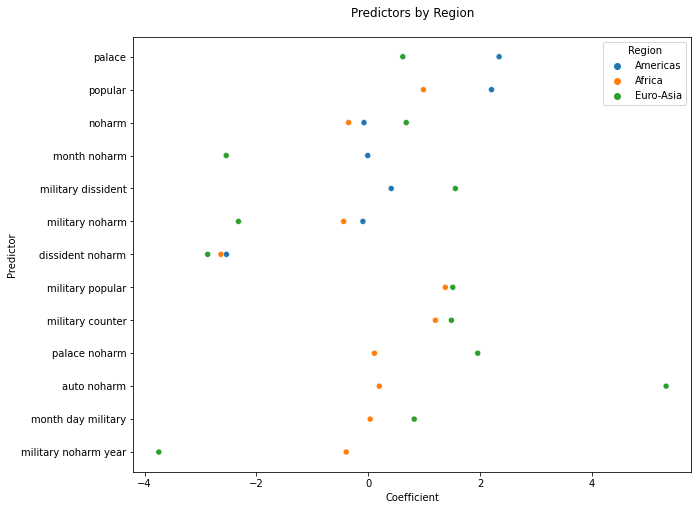

In [74]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df, x=df.Coefficient, y=df.Predictor, hue=df.Region)
scatter.set_title('Predictors by Region', fontdict={'fontsize':12}, pad=20);

# Comparision of Time Frames
Here we will two sub time frames that will be broken up based on the amount of observations. We will use a graph to see the amount of observations based on each year. From the below countplot, we can see that a nice even split of observation would come at 1975. We decided on looking for an equal split in order to avoid dimensionality issues as well as because we didn't find any historical time frames that were encompassed in our data that would impact all of the countries in the dataframe. For example, we were considering on using 1945-1989 as a time frame to evaluate how the Cold War could impact the success rate of coups but since we noticed through our geographic sub regioning that most of the observations came from Africa and Latin American coutnries. Africa and Latin American countries were not as impacted by the war as westernized countries (North America and Europe). We felt that this would not be a reasonable split as well as other historical time frames. We will still plan to use historical events in our evaluation of the coefficients but we decided not to use them as a metric. We will be using the same function above in order to get the cofficient lists and the false positive/false negative rates.

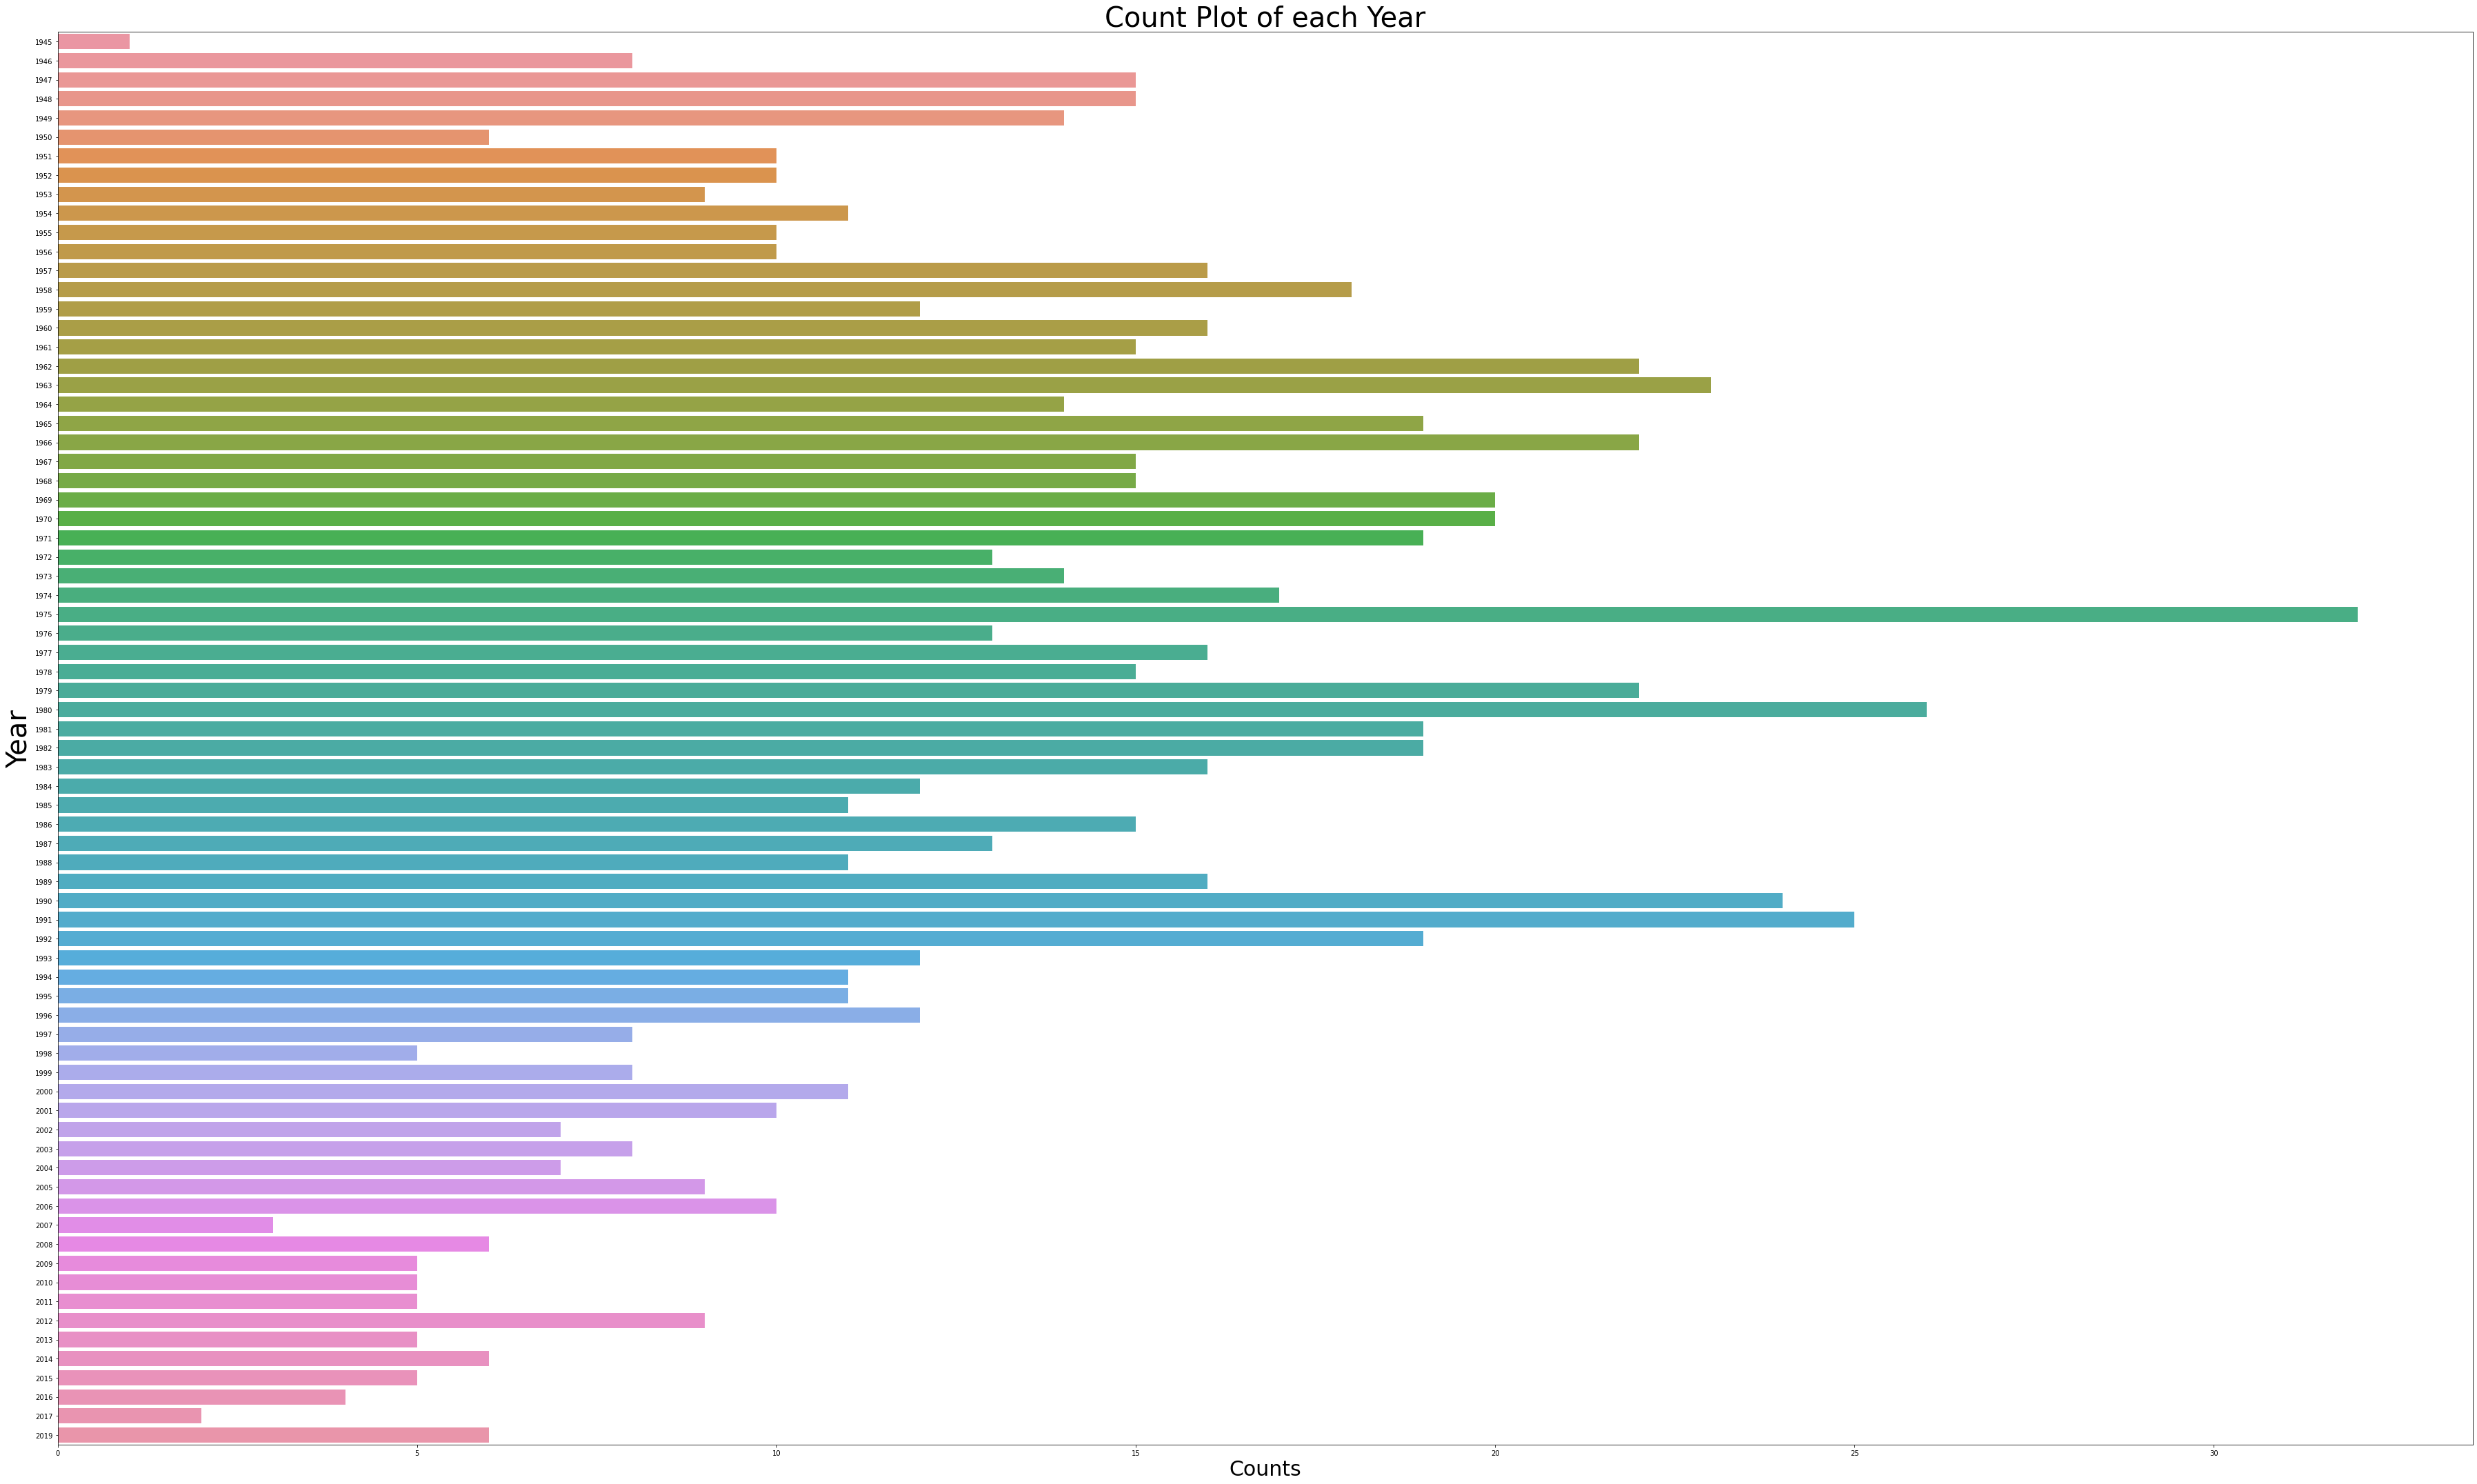

In [75]:
plt.figure(figsize=(50,30))
ax = sns.countplot(y="year", data=coup_df)
plt.title("Count Plot of each Year", fontsize = 40)
plt.xlabel("Counts", fontsize = 30)
plt.ylabel("Year", fontsize = 40)
plt.tight_layout()
plt.show()

In [76]:
latter_df = coup_selected[coup_selected.year > 1975]
earlier_df = coup_selected[coup_selected.year <= 1975]


In [77]:
print("1945-1975 dataframe: \n")
after75 = outputs(latter_df, regions=False)

1945-1975 dataframe: 

Accuracy score from train data: 75.668%
Accuracy score from test data: 79.31%

 Sorted Positive Coefficients 

	month foreign                 0.0567
	month foreign noharm          0.0567
	day foreign                   0.0671
	day foreign noharm            0.0671
	month                         0.1431
	cowcode month                 0.2212
	palace noharm                 0.2390
	military dissident            0.2863
	palace                        0.5331
	rebel                         0.5537
	military popular              0.5599
	auto noharm                   0.6194
	popular                       1.8845
---------------------------------------------
Sorted Negative Coefficients

	dissident noharm              -2.8306
	military noharm               -0.5684
	injured                       -0.5668
	cowcode military noharm       -0.2392


In [78]:
print("1976-2019 dataframe: \n")
before75 = outputs(earlier_df, regions=False)

1976-2019 dataframe: 

Accuracy score from train data: 70.497%
Accuracy score from test data: 77.698%

 Sorted Positive Coefficients 

	palace                        0.0172
---------------------------------------------
Sorted Negative Coefficients

	dissident                     -1.8602


In [79]:
rates = PrettyTable()
rates.field_names = ["Time Frame", "FPR", "FNR"]
rates.add_row(["1945-1975", round(before75[2],3), round(before75[3],3)])
rates.add_row(["1976-2019", round(after75[2],3), round(after75[3],3)])
print("False Positive Rates & False Negative Rates for each Time Frame")
print(rates)

False Positive Rates & False Negative Rates for each Time Frame
+------------+-------+-------+
| Time Frame |  FPR  |  FNR  |
+------------+-------+-------+
| 1945-1975  | 0.388 | 0.069 |
| 1976-2019  | 0.138 |  0.31 |
+------------+-------+-------+


## Visualization & Analysis of Findings

In [80]:
def add_element(list_tuples, element):
    # A helper function to create dataframe
    result = []
    for t in list_tuples:
        t = list(t)
        t.append(element)
        result.append(tuple(t))
    return result

# Organize data
early = add_element(before75[0], "1945-1975")
later = add_element(after75[0], "1976-2019")

all_dfs = [early + later]

# create DataFrame using data
df = pd.DataFrame(all_dfs[0], columns =['Predictor', 'Coefficient', 'TimeFrame'])
a = df.pivot('TimeFrame', 'Predictor', 'Coefficient')
a


Predictor,auto noharm,cowcode military noharm,cowcode month,day foreign,day foreign noharm,dissident,dissident noharm,injured,military dissident,military noharm,military popular,month,month foreign,month foreign noharm,palace,palace noharm,popular,rebel
TimeFrame,,,,,,,,,,,,,,,,,,
1945-1975,NaN,NaN,NaN,NaN,NaN,-1.860152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017205,NaN,NaN,NaN
1976-2019,0.61941,-0.23921,0.221155,0.067091,0.067091,NaN,-2.830641,-0.56681,0.286291,-0.568355,0.559866,0.143066,0.056701,0.056701,0.533090,0.238956,1.884462,0.553732


In [81]:
a = a.dropna(axis=1, how='any', thresh=2)
# a.columns # this gives us the list of predictors where at least 2 regions share a predictor
a

Predictor,palace
TimeFrame,
1945-1975,0.017205
1976-2019,0.533090


In [82]:
early_preds = [tup[0] for tup in early]
print("The predictors that are considered significant for the time frame 1945-1975 are", early_preds)

The predictors that are considered significant for the time frame 1945-1975 are ['dissident', 'palace']


In [83]:
later_preds = [tup[0] for tup in later]
print("The predictors that are considered significant for the time frame 1945-1975 is", later_preds)

The predictors that are considered significant for the time frame 1945-1975 is ['month', 'rebel', 'palace', 'popular', 'injured', 'cowcode month', 'month foreign', 'day foreign', 'military dissident', 'military popular', 'military noharm', 'dissident noharm', 'palace noharm', 'auto noharm', 'cowcode military noharm', 'month foreign noharm', 'day foreign noharm']


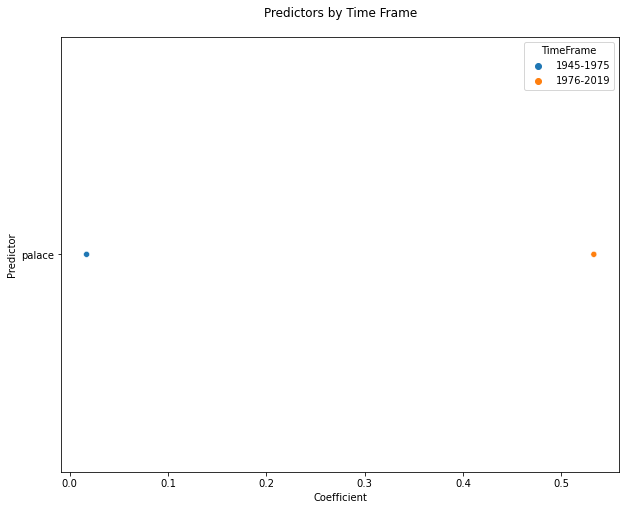

In [84]:
selected_preds = ['palace']
df = df.loc[df['Predictor'].isin(selected_preds)]
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df, x=df.Coefficient, y=df.Predictor, hue=df.TimeFrame)
scatter.set_title('Predictors by Time Frame', fontdict={'fontsize':12}, pad=20);

## ========================================== END OF THE NOTEBOOK ==========================================